# Zipping Calibration Study Analysis

The purpose of this study is to assess whether our zipping paradigm can possibly yield large enough item-specific differences in RT.
We are also hoping to compare the task-general learning to these item-specific differences.

To do this we created a common/ rare design, where people perform the zipping task on a 50-50 split of two common composite stimuli (that are each probed in a specific direction), and a set of random composite stimuli.



In [263]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [264]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [265]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping_calibration']

# which iteration name should we use?
# iteration_name = 'zipping_calibration_sona_masks_0' #'zipping_calibration_sona_dev'
# iteration_name = 'zipping_calibration_pilot_3_sona' # 'zipping_calibration_pilot_3_prolific'
# iteration_name = 'zipping_calibration_pilot_3_prolific' 
iteration_name = 'zipping_calibration_pilot_3_sona_stims_1' 

iteration_names = [iteration_name]

# variables to check integrity of data
# numTrials = 8

In [266]:
# query = coll.find()
# df_all = pd.DataFrame(query)
# df_all.iterationName.unique()

In [267]:
query = coll.find({"$and":[
                        {'trial_type':'survey-text'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_survey = pd.DataFrame(query)
list(df_survey['response'])

[{'technical': 'No', 'confused': 'Nothing', 'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'None',
  'confused': 'In the beginning yes but I got the hang of it',
  'comments': 'It was somewhat fun, but my eyes got tired '},
 {'technical': 'No', 'confused': 'No', 'comments': 'No'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'no', 'confused': 'No', 'comments': 'No'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'No',
  'confused': 'No',
  'comments': 'I kept accidentally pressing M for yes and Z for no when I tried reacting too fast'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no, thank you!'},
 {'technical': 'no', 'confused': 'no', 'comments': ''},
 {'technical': 'no', 'confused': 'nothing', 'comments': 'no '},
 {'technical': 'No',
  'confused': 'The instructions were very clear and easy to  understand :)',
  'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': '

In [268]:
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
#                         {'datatype':'trial_end'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_zip = pd.DataFrame(query)
df_zip

,_id,rt,stimulus,response,response_correct,stimURL,practice,composite_id,composite_duration,gap_duration,...,datatype,experimentName,iterationName,workerID,gameID,response_key_dict,studyLocation,block_number,condition,composite_talls_name
0,6261d4815698fd325c0a9992,3382.0,../img/practice_trials/practice_square_composi...,m,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
1,6261d4885698fd325c0a9993,2040.0,../img/practice_trials/practice_square_composi...,m,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
2,6261d48e5698fd325c0a9994,973.8,../img/practice_trials/practice_square_composi...,z,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
3,6261d4945698fd325c0a9995,1068.0,../img/practice_trials/practice_square_composi...,z,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
4,6261d4a75698fd325c0a999a,807.1,https://zipping-composites-png-rerender.s3.ama...,z,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_125_118,600,400,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,0.0,common_tall,talls_125_118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15653,6269a9d75698fd325c0adbe2,14.7,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_101_111,100,400,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,39599,6810-20d2042f-7983-4ad8-b37a-5a8a4ddc2322,"{'valid': 'z', 'invalid': 'm'}",SONA,2.0,common_wide,talls_101_111
15654,6269a9db5698fd325c0adbe3,70.0,https://zipping-composites-png-rerender.s3.ama...,z,0,https://zipping-composites-png-rerender.s3.ama...,False,talls_100_118,100,400,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,39599,6810-20d2042f-7983-4ad8-b37a-5a8a4ddc2322,"{'valid': 'z', 'invalid': 'm'}",SONA,2.0,common_tall,talls_100_118
15655,6269a9df5698fd325c0adbe4,32.1,https://zipping-composites-png-rerender.s3.ama...,m,0,https://zipping-composites-png-rerender.s3.ama...,False,talls_101_111,100,400,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,39599,6810-20d2042f-7983-4ad8-b37a-5a8a4ddc2322,"{'valid': 'z', 'invalid': 'm'}",SONA,2.0,common_wide,talls_101_111
15656,6269a9e25698fd325c0adbe5,152.1,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_125_118,100,400,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,39599,6810-20d2042f-7983-4ad8-b37a-5a8a4ddc2322,"{'valid': 'z', 'invalid': 'm'}",SONA,2.0,rare,talls_125_118


In [269]:
df_zip.columns

Index(['_id', 'rt', 'stimulus', 'response', 'response_correct', 'stimURL',
       'practice', 'composite_id', 'composite_duration', 'gap_duration',
       'chunk_duration', 'participant_condition', 'compatible_trial',
       'validity', 'part_type', 'part_a', 'part_b', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_num', 'key_presses',
       'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'datatype', 'experimentName', 'iterationName', 'workerID', 'gameID',
       'response_key_dict', 'studyLocation', 'block_number', 'condition',
       'composite_talls_name'],
      dtype='object')

In [270]:
df_zip = df_zip[~df_zip.workerID.isna()]
df_survey = df_survey[~df_survey.workerID.isna()]

In [271]:
df_zip.loc[:,'common'] = ~(df_zip.condition == 'rare')

/Users/will/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Remove identifiable info and save

In [272]:
df_zip = df_zip.drop('workerID', axis='columns')
df_zip.to_csv('df_zipping_{}.csv'.format(iteration_name))

### Apply exclusion criteria

In [273]:
df_zip_trials = df_zip[~df_zip.condition.isna()]
df_zip_w_practice = df_zip.copy()
# TODO: replace with df_zip.practice when column added

In [274]:
# complete datasets
full_dataset_ids = (df_zip_trials.groupby('gameID').apply(len) == 144)\
                        .index[(df_zip_trials.groupby('gameID').apply(len) == 144)]
df_zip_trials = df_zip_trials.loc[df_zip.gameID.isin(full_dataset_ids)]

In [275]:
df_zip = df_zip_trials

In [276]:
# low accuracy
p = df_zip.groupby('gameID').response_correct.mean() > 0.5
ppt_greater_chance = list(p[p].index)
print(str(len(df_zip.groupby('gameID')) - len(ppt_greater_chance)) + ' ppts removed')

df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()
print(str(len(ppt_greater_chance)) + ' ppts left')


11 ppts removed
94 ppts left


In [277]:
# exclude really slow ppts

df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

df_zip = df_zip[~df_zip.gameID.isin(list(df_zip_ppt_means['rt'].index[df_zip_ppt_means['rt'] > 3000]))]

print(str(df_zip.gameID.nunique()) + ' ppts left')

90 ppts left


In [278]:
# slow RTs
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [279]:
df_zip['flagRT'].sum()

66

### Add useful columns

In [280]:
df_zip.loc[:,'trial_bin'] = np.round(df_zip.trial_num/12)

### plot setup

In [281]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

### check study design

In [282]:
# check experiment-side saving of accuracy (response_correct) with manual calculation

df_zip.loc[:,'expected_response'] = df_zip.apply(lambda row: row.response_key_dict[row.validity],axis=1)
df_zip.loc[:,'recalculated_response_correct'] = df_zip.expected_response == df_zip.response
assert((df_zip.recalculated_response_correct == df_zip.response_correct).all())

No handles with labels found to put in legend.


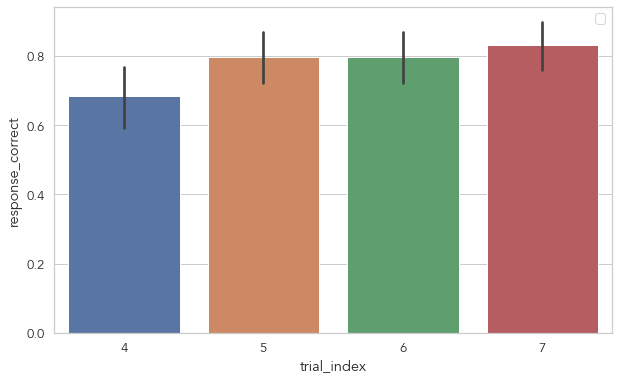

In [283]:
# So people understand practice trials?

fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip_w_practice[df_zip_w_practice.condition.isna()], 
              y= "response_correct", 
              x= "trial_index",
              )

plt.legend(bbox_to_anchor=(1,1))

In [284]:
df_zip.groupby('composite_duration')['gameID'].nunique()

composite_duration
100    20
300    19
600    27
800    24
Name: gameID, dtype: int64

## Questions to answer with these analyses

*Frequency*: common vs. rare
Frequency is our main IV here.
Common vs rare over blocks.

*Zipping performance*: how good (fast and accurate) are they at the task?


#### Effect of decomposition experience on zipping performance
- Are common trials faster (particularly in later reps)?
- What contributes to a larger diff between common and rare?
    - Composite duration? (i.e. the time people have to look at and decompose the stimulus?
- Is there a d' difference?
- Is there an accuracy difference
- Plot number of times that a composite has been seen so far?

#### Does practice on a part (rather than a whole composite) improve zipping performance?
- Plot number of times that a part has been seen so far?

#### Which particular stimuli are most susceptible to frequency effects?
- Which composites?
- Which parts?


#### 

#### 

#### 


## 'Calibration'- what are the overall effects of composite duration?

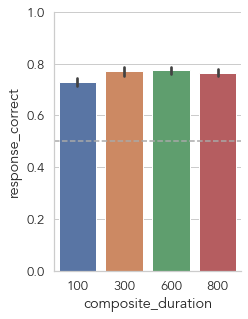

In [285]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="composite_duration",
#                 col="block_number",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

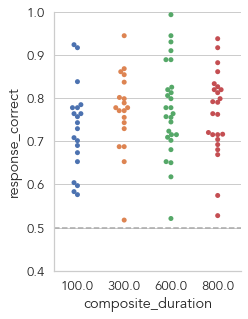

In [286]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)].groupby('gameID').mean(),
                y="response_correct", 
                x="composite_duration",
                dodge=True,
                kind="swarm",
                height=4.6,
                aspect=0.8)
plt.ylim(0.4,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

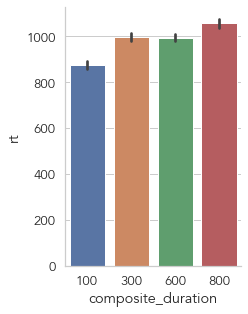

In [287]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="composite_duration",
#                 col="block_number",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

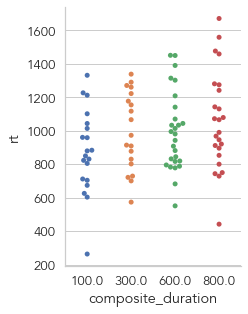

In [288]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)].groupby('gameID').mean(),
                y="rt", 
                x="composite_duration",
                dodge=True,
                kind="swarm",
                height=4.6,
                aspect=0.8)
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

## Effect of decomposition experience on zipping performance

### RT

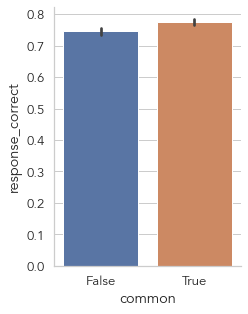

In [289]:
# Are people faster in common trials?

g = sns.catplot(data=df_zip[~df_zip.flagRT],
#                 col="composite_duration", 
                x="common",
                y="response_correct", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

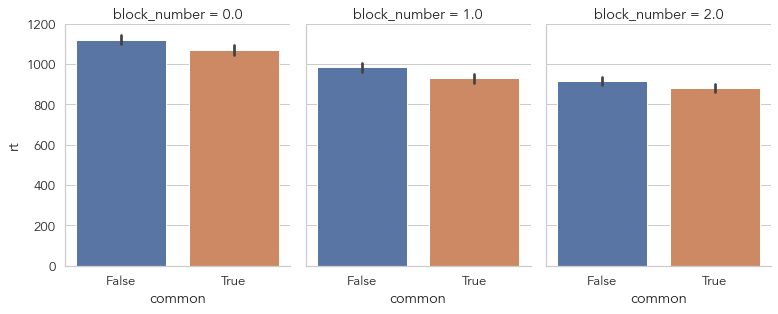

In [290]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
#                 row="composite_duration", 
                col="block_number",
                x="common",
                y="rt", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

In [291]:
# Ah. So it looks like people are waiting until after the parts disappear to respond.. or not!


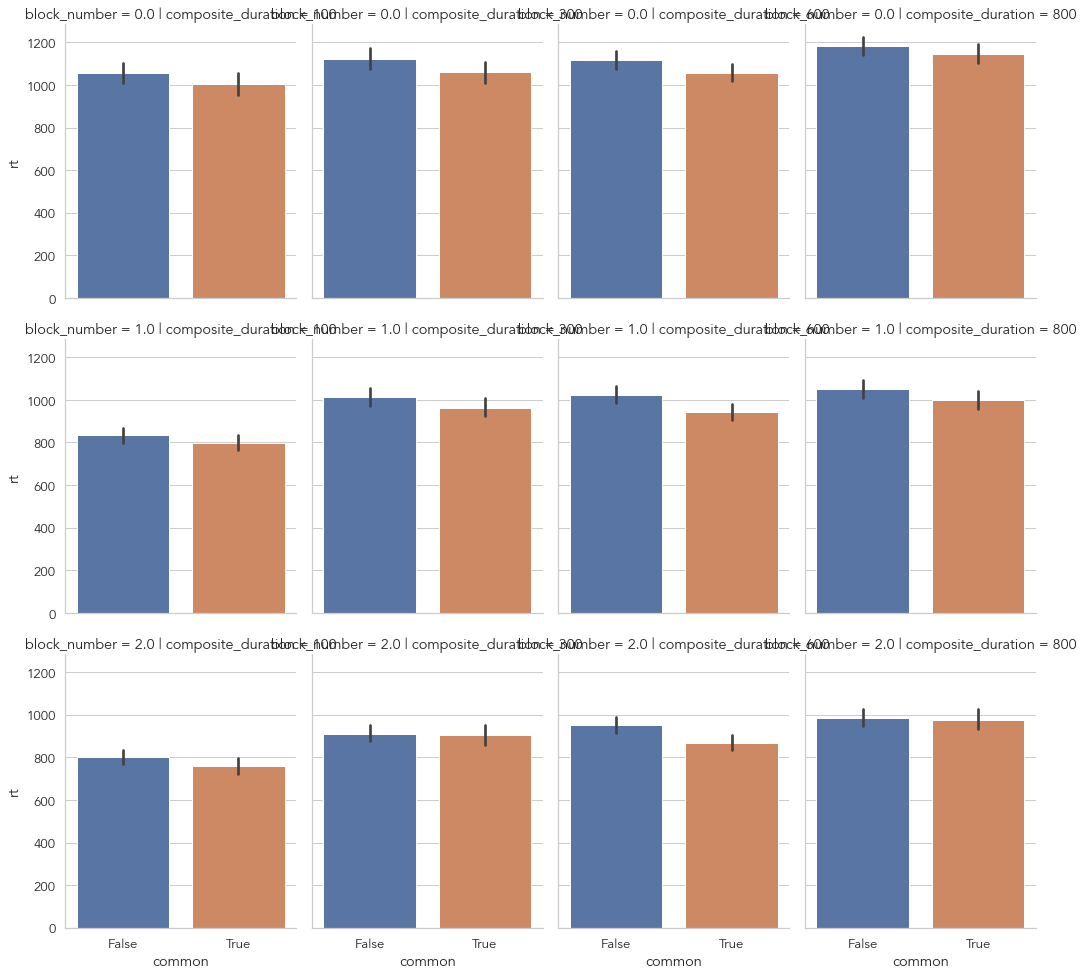

In [292]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                col="composite_duration", 
                row="block_number",
                x="common",
                y="rt", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

<Figure size 720x432 with 0 Axes>

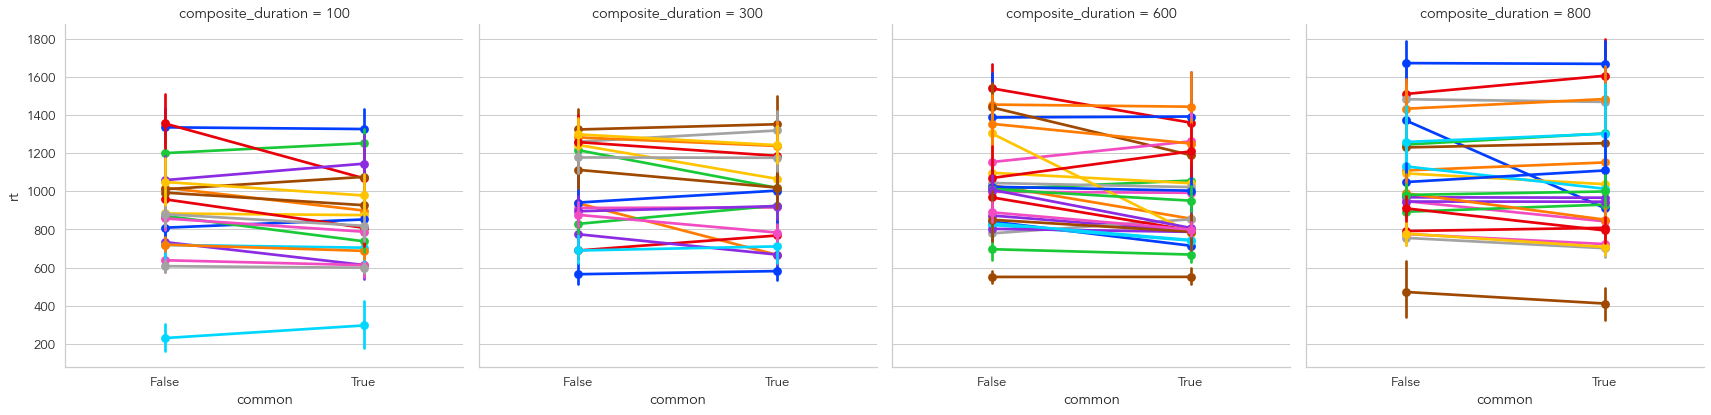

In [293]:
# Are people faster in compatible trials?

fig = plt.figure(figsize=(10,6))

g = sns.FacetGrid(df_zip[~df_zip.flagRT], height=6, col="composite_duration") # row="block_number"

g.map_dataframe(sns.pointplot,
                  y="rt",
                  x="common", 
                  hue="gameID",
                  palette="bright")

(array([ 3.,  5.,  5., 14., 13., 24., 10.,  7.,  8.,  1.]),
 array([0.52083333, 0.56805556, 0.61527778, 0.6625    , 0.70972222,
        0.75694444, 0.80416667, 0.85138889, 0.89861111, 0.94583333,
        0.99305556]),
 <BarContainer object of 10 artists>)

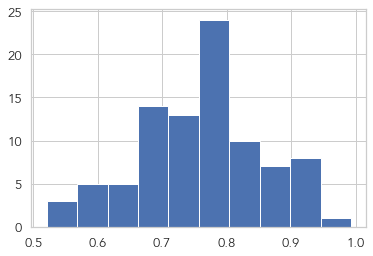

In [294]:
plt.hist(df_zip.groupby('gameID')['response_correct'].mean(), bins=10)

In [295]:
df_zip.groupby('gameID')['response_correct'].mean()

gameID
0016-de5f682d-6599-4aa5-a311-3050bb069d0c    0.923611
0023-f256dea4-1f52-466b-aeac-bb16f9ecc672    0.722222
0174-8d01a4e4-fb35-4dc3-9ce8-e2f1f8f360e0    0.944444
0185-05d94f3e-7370-41fb-a156-c3d9eecb9e9c    0.909722
0241-311cc775-36cc-4897-9613-f4fed23d6495    0.576389
                                               ...   
9817-e610bd3d-a0b8-4312-84ec-9bf760554938    0.944444
9824-c9549ff0-af37-474a-a938-7475d502a751    0.652778
9836-7ab1f26f-97fb-4046-84f9-a1133e1493cd    0.687500
9894-fd23fbc3-58cd-4789-a692-6d680b6ce841    0.520833
9959-0623a365-b7b9-412a-8759-d5c01543555a    0.784722
Name: response_correct, Length: 90, dtype: float64

### Plot differences between common and rare

In [296]:
def rare_common_diff(means, value_col='rt'):
    '''
    Given a dataframe of means
    '''
    
    diffs = (means.loc[means.common, value_col].reset_index(drop=True) - \
            means.loc[~means.common, value_col].reset_index(drop=True))
    
    assert(len(diffs) == 1)
    
    return pd.Series({value_col+'_diff' : diffs[0]})

In [297]:
def get_means(df, grouping_cols, value_col='rt'):
    '''
    grouping_cols: columns to average over
    value_col: values you want differences of
    '''
    df_means = df.groupby(grouping_cols)[value_col].mean().reset_index()

    return df_means

In [298]:
def get_diffs(df, grouping_cols, comparison_col='common', value_col='rt'):
    '''
    grouping_cols: columns to average over
    comparison_col: column with binary variable to compare
    value_col: values you want differences of
    '''
    df_means = get_means(df, 
                         grouping_cols = grouping_cols + [comparison_col], 
                         value_col = value_col)
    
    df_diffs = df_means.groupby(grouping_cols).apply(rare_common_diff, value_col=value_col)
    
    return df_diffs.reset_index()

In [299]:
df_rt_diffs_all = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['gameID'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_diffs

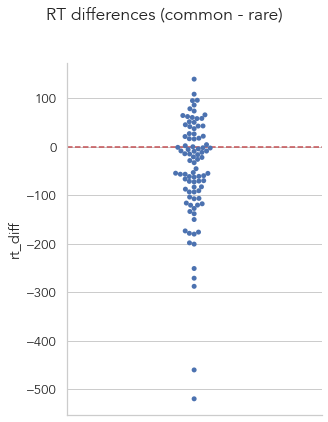

In [300]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.catplot(
                y="rt_diff",
                dodge=True,
                kind="swarm",
                data=df_rt_diffs_all,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences (common - rare)')
plt.axhline(y=0, color='r', linestyle='--')

In [301]:
# get means and merge
df_ppt_means = df_zip[~df_zip.flagRT].groupby('gameID')[['rt','response_correct']].mean()

In [302]:
df_rt_diffs_all_plus = df_rt_diffs_all.merge(df_ppt_means, how='left', on='gameID')

In [303]:
# what predicts RT diff?

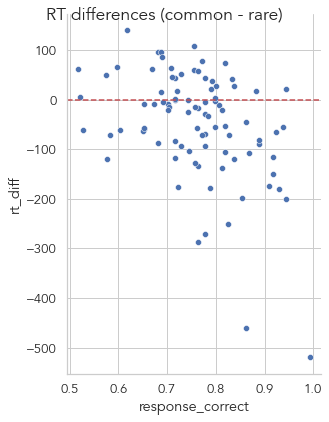

In [304]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.relplot(x='response_correct',
                y="rt_diff",
                kind="scatter",
                data=df_rt_diffs_all_plus,
                height=6,
                aspect=0.8)

# g.fig.subplots_adjust(top=0.85)
plt.axhline(y=0, color='r', linestyle='--')
_ = g.fig.suptitle('RT differences (common - rare)')

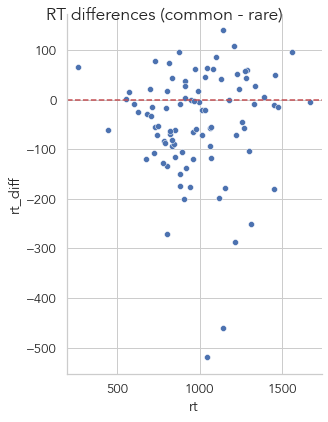

In [305]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.relplot(x='rt',
                y="rt_diff",
                kind="scatter",
                data=df_rt_diffs_all_plus,
                height=6,
                aspect=0.8)

# g.fig.subplots_adjust(top=0.85)
plt.axhline(y=0, color='r', linestyle='--')
_ = g.fig.suptitle('RT differences (common - rare)')

In [306]:
df_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration', 'gameID'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_diffs

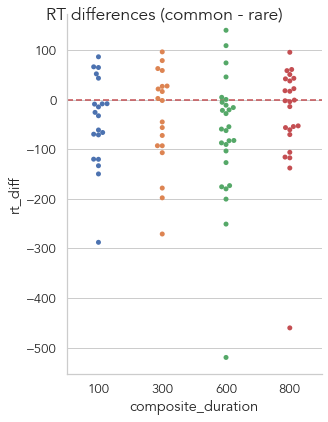

In [307]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.catplot(x="composite_duration", 
                y="rt_diff",
                dodge=True,
                kind="swarm",
                data=df_rt_diffs,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=0.85)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('RT differences (common - rare)')

In [308]:
df_rt_diffs_plus = df_rt_diffs.merge(df_ppt_means, how='left', on='gameID')

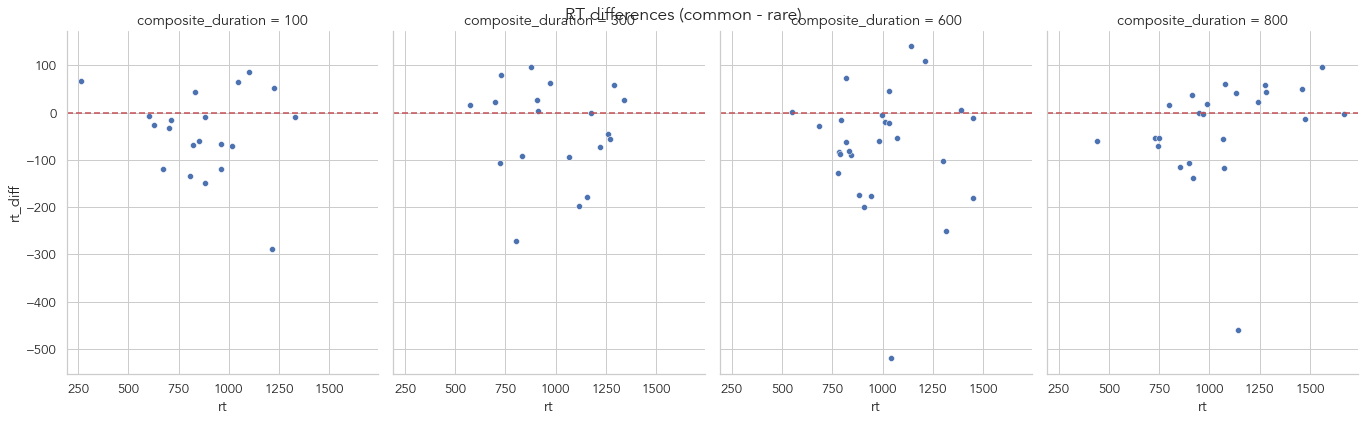

In [309]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.relplot(col="composite_duration", 
                x= "rt",
                y="rt_diff",
                kind="scatter",
                data=df_rt_diffs_plus,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=0.85)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('RT differences (common - rare)')

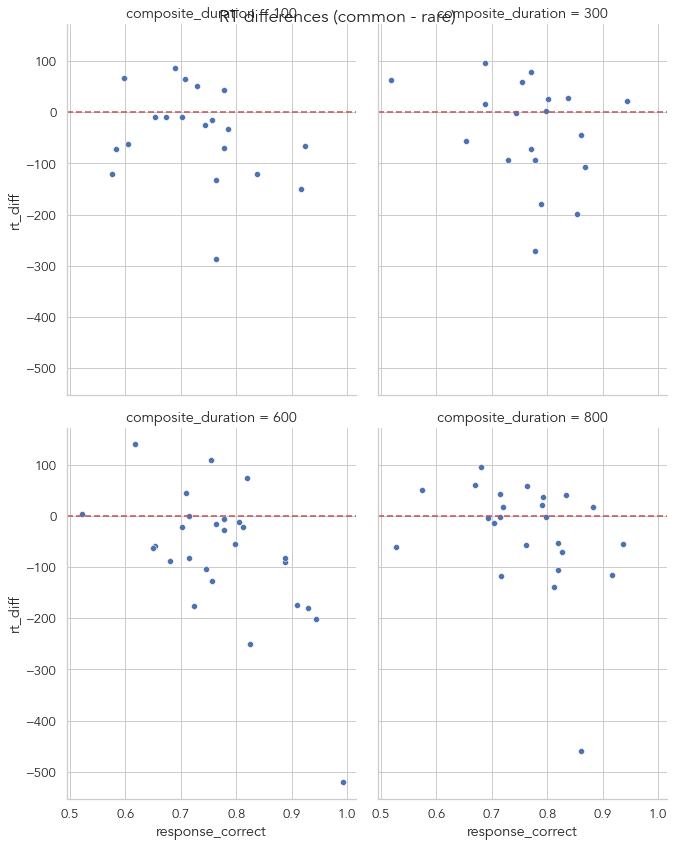

In [310]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.relplot(col="composite_duration", 
                col_wrap=2,
                x= "response_correct",
                y="rt_diff",
                kind="scatter",
                data=df_rt_diffs_plus,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=1.05)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('RT differences (common - rare)')

In [311]:
df_acc_diffs = get_diffs(df_zip,
                      grouping_cols = ['composite_duration', 'gameID'],
                      comparison_col = 'common',
                      value_col = 'response_correct')
# df_diffs

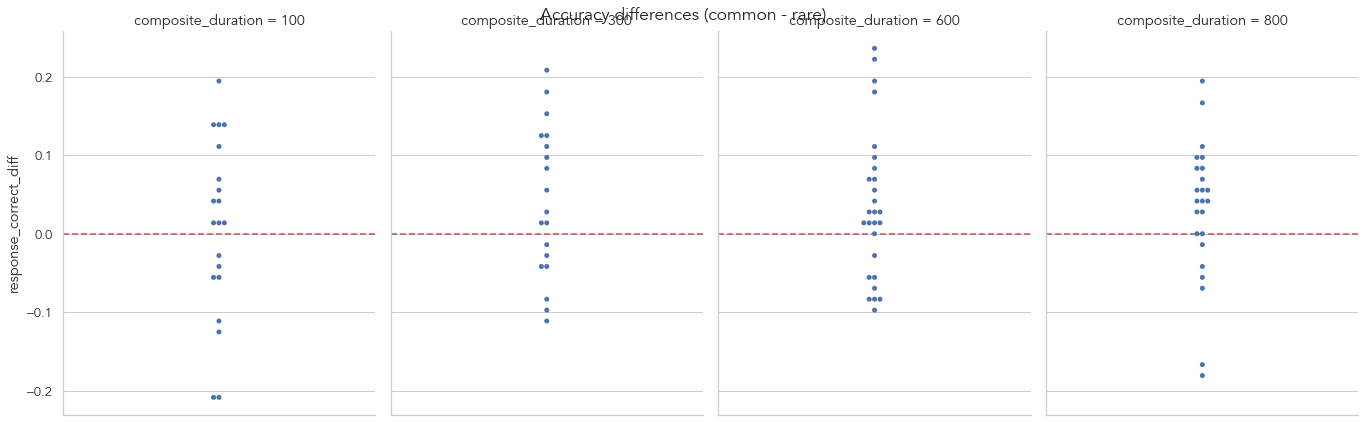

In [312]:
# Is there a frequency effect on accuracy? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="response_correct_diff",
                dodge=True,
                kind="swarm",
                data=df_acc_diffs,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=0.85)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('Accuracy differences (common - rare)')

In [313]:
def plot_diffs(group):
    plt.figure()
    plt.hist(group,
            bins=10)

#### Differences across blocks

Can I go more granular than diff between common and rare for each ppt?

In [314]:
df_block_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration', 'gameID', 'block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

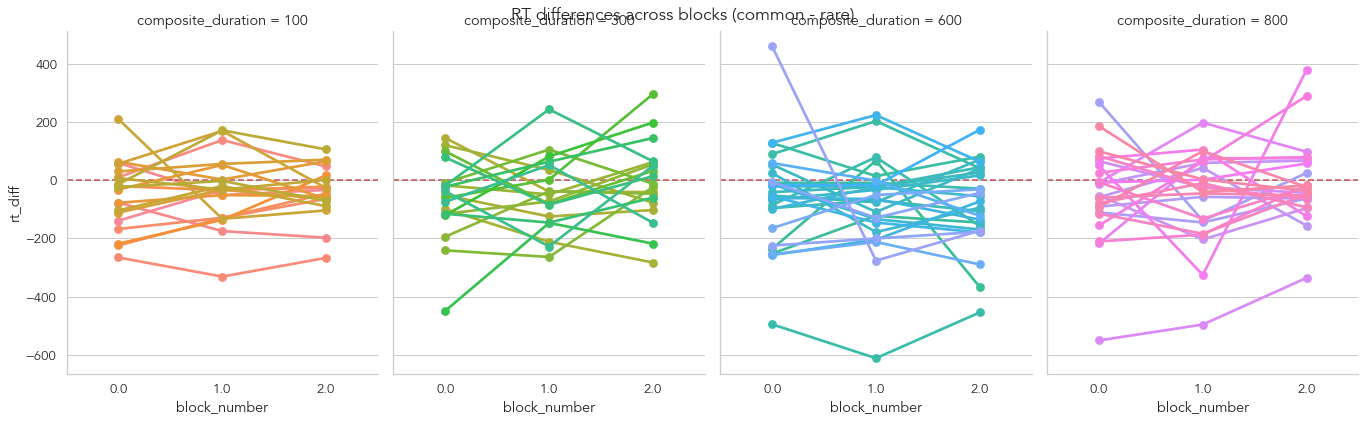

In [315]:
# Does a frequency effect on RT develop over time? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="gameID",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_rt_diffs,
                height=6,
                aspect=0.8,
                legend = False)

g.fig.subplots_adjust(top=0.85)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('RT differences across blocks (common - rare)')

In [316]:
df_block_acc_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration', 'gameID', 'block_number'],
                      comparison_col = 'common',
                      value_col = 'response_correct')

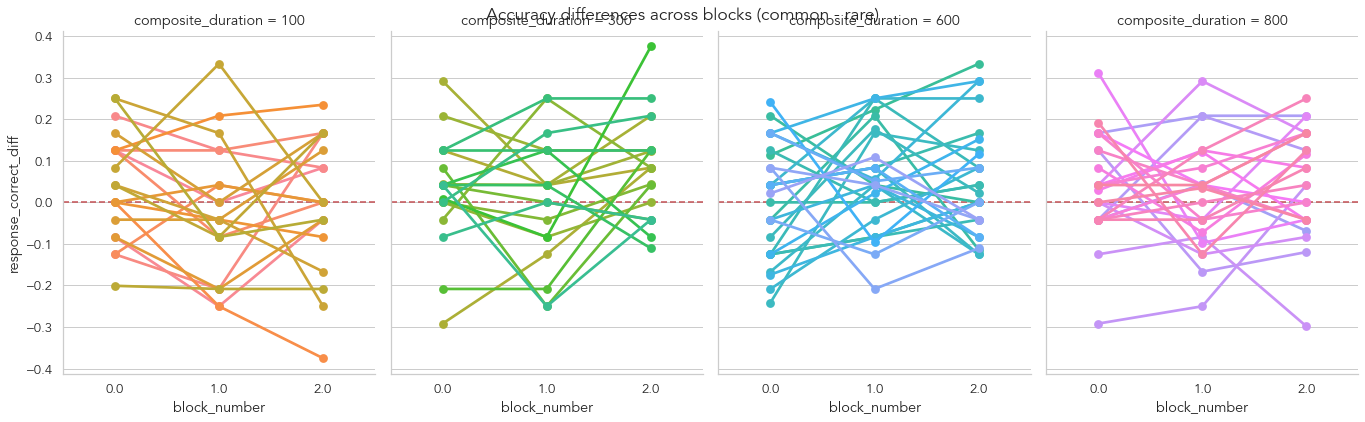

In [317]:
# Is there a frequency effect on accuracy develop over time? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="response_correct_diff",
                hue="gameID",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_acc_diffs,
                height=6,
                aspect=0.8,
                legend = False)
g.fig.subplots_adjust(top=0.85)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('Accuracy differences across blocks (common - rare)')

#### What contributes to larger diffs in RT?

In [318]:
df_block_orientation_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration','part_type', 'gameID', 'block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

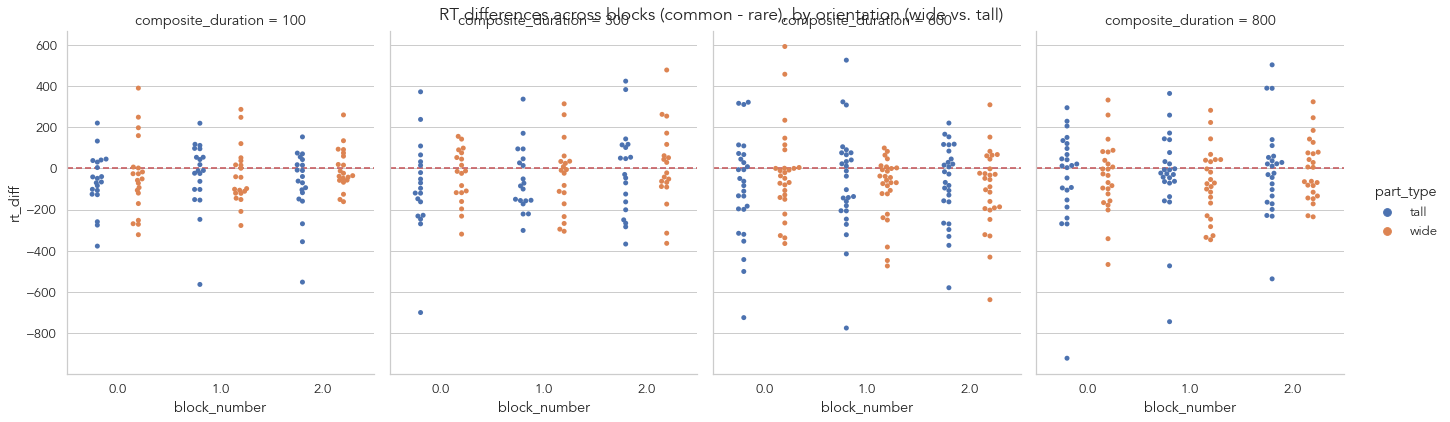

In [319]:
# Is there a frequency effect on accuracy develop over time? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="part_type",
                x="block_number",
                dodge=True,
                kind="swarm",
                data=df_block_orientation_rt_diffs,
                height=6,
                aspect=0.8,
                legend = True)
g.fig.subplots_adjust(top=0.85)
g.map(plt.axhline, y=0, color="r", dashes=(4, 2))
_ = g.fig.suptitle('RT differences across blocks (common - rare), by orientation (wide vs. tall)')

## Find stimuli that yield the biggest frequency effects (i.e. are learnable)

In [320]:
df_block_composite_rt_diffs = get_diffs(df_zip,
                      grouping_cols = ['composite_duration','composite_id','block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

In [321]:
df_block_composite_rt_diffs

,composite_duration,composite_id,block_number,rt_diff
0,100,talls_097_102,0.0,-27.066667
1,100,talls_097_102,1.0,139.323611
2,100,talls_097_102,2.0,58.718056
3,100,talls_097_116,0.0,-299.856944
4,100,talls_097_116,1.0,-251.073611
...,...,...,...,...
307,800,talls_126_115,1.0,489.912121
308,800,talls_126_115,2.0,681.546212
309,800,talls_127_122,0.0,-350.309420
310,800,talls_127_122,1.0,-315.524275


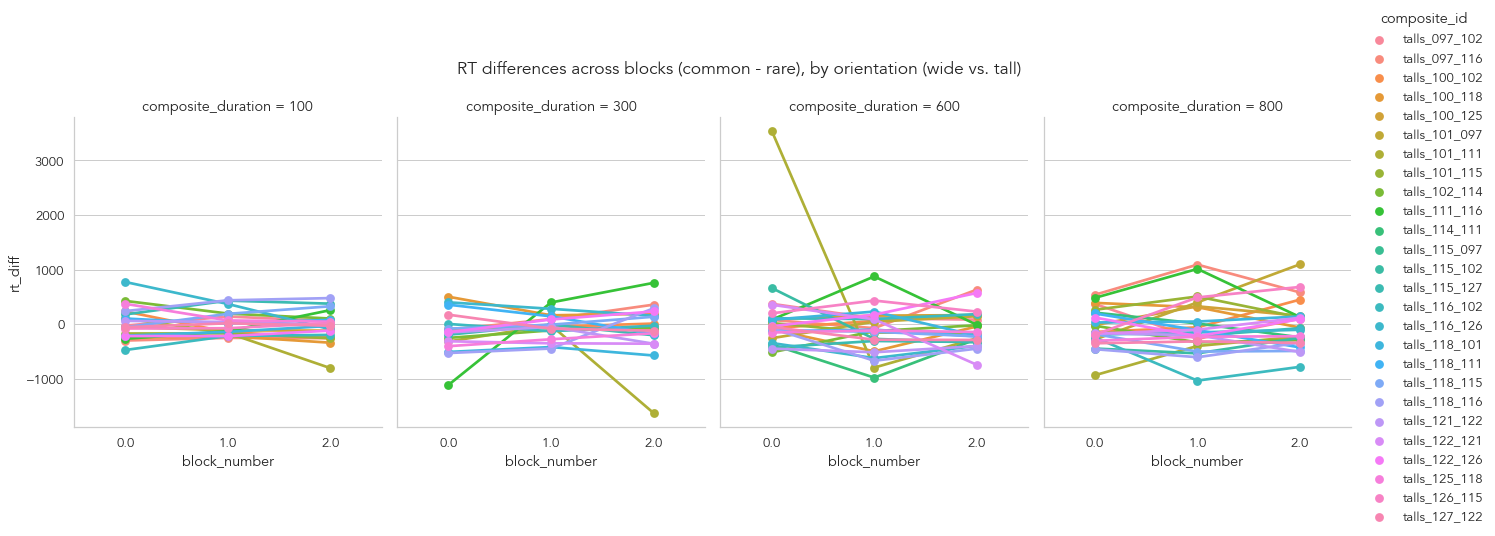

In [322]:
# Do any particular composites stand out as most learnable?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="composite_id",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_composite_rt_diffs,
                height=6,
                aspect=0.8,
                legend = True)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences across blocks (common - rare), by orientation (wide vs. tall)')

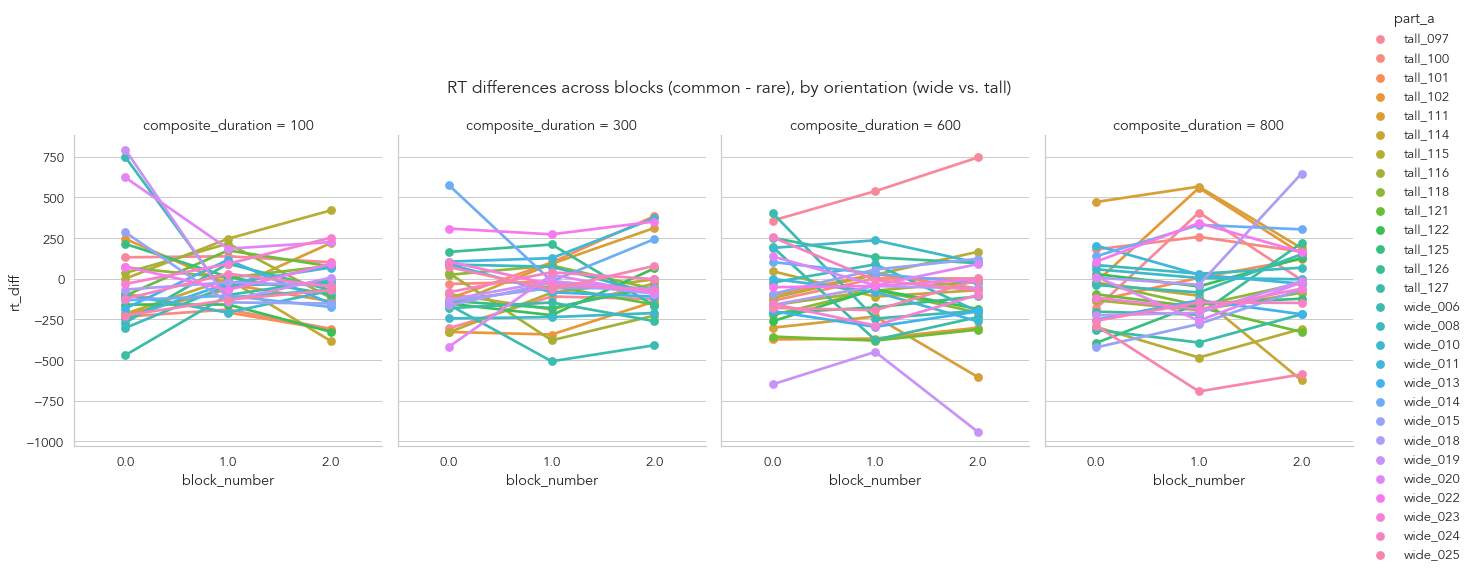

In [323]:
# Are there any individual parts that stand out as most learnable? 
# WARNING [looking only at part a here- swap in for part b too/ aggregate somehow]

df_block_part_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration','part_a','block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="part_a",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_part_rt_diffs,
                height=6,
                aspect=0.8,
                legend = True)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences across blocks (common - rare), by orientation (wide vs. tall)')

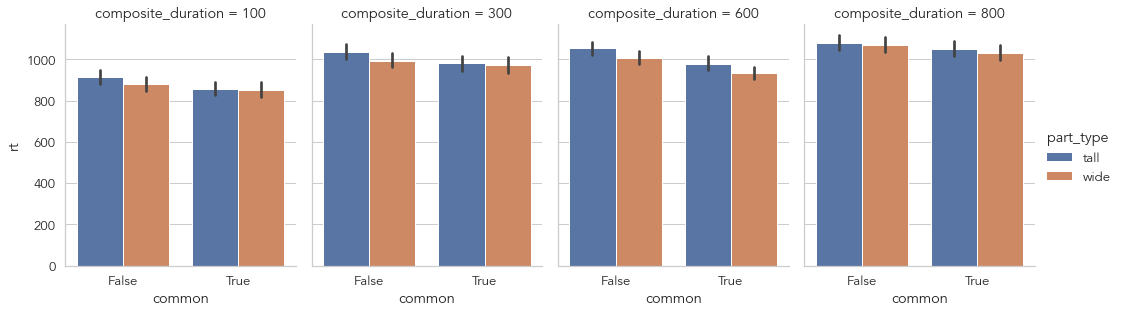

In [324]:
g = sns.catplot(col="composite_duration", 
                x="common",
                y="rt", 
                hue="part_type",
                dodge=True,
                kind="bar",
                data=df_zip[~df_zip.flagRT],
                height=4.6,
                aspect=0.8)

In [325]:
df_zip.groupby('common')['rt'].mean()

common
False    1061.250262
True     1024.176296
Name: rt, dtype: float64

### accuracy

<AxesSubplot:xlabel='composite_duration', ylabel='response_correct'>

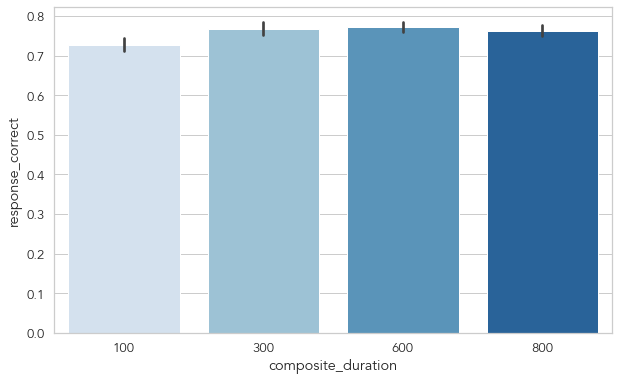

In [326]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration",
              palette='Blues')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

No handles with labels found to put in legend.


Text(0.5, 1.0, 'accuracy')

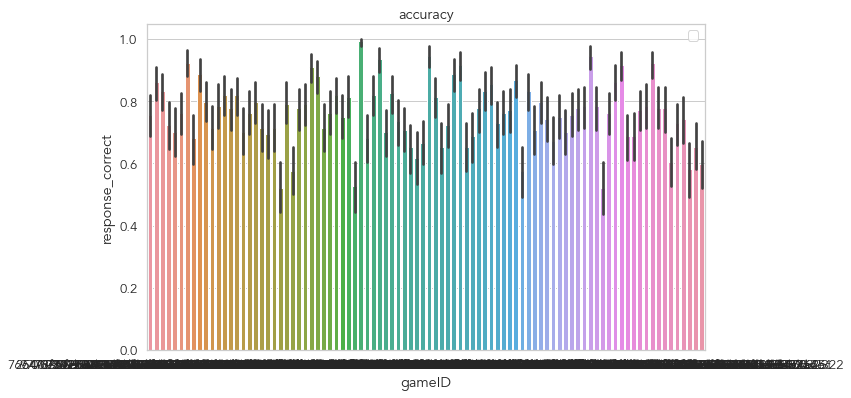

In [327]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
#               x="composite_duration",
              x="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('accuracy')

<AxesSubplot:xlabel='trial_bin', ylabel='rt'>

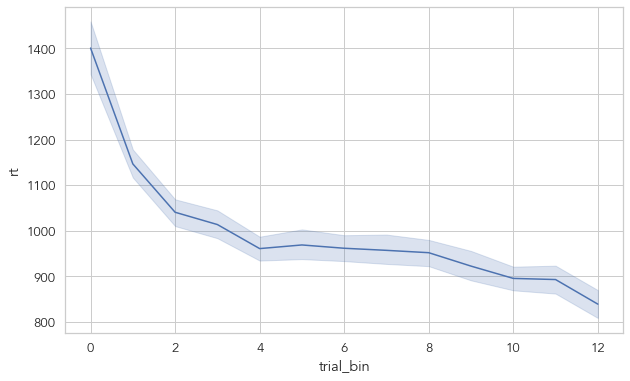

In [328]:
fig = plt.figure(figsize=(10,6))

sns.lineplot(data=df_zip[~df_zip.flagRT], 
              y="rt", 
              x="trial_bin")

# plt.legend(bbox_to_anchor=(1,1))

<AxesSubplot:xlabel='trial_bin', ylabel='response_correct'>

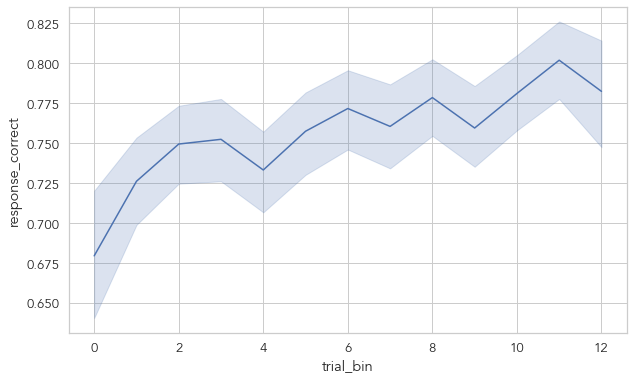

In [329]:
fig = plt.figure(figsize=(10,6))

sns.lineplot(data=df_zip, 
              y="response_correct", 
              x="trial_bin")

# plt.legend(bbox_to_anchor=(1,1))

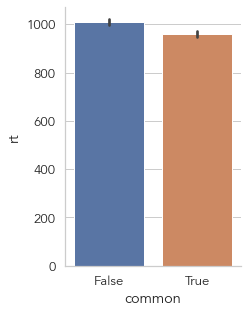

In [330]:
# How does rt change across condition?

# Are people faster in common trials?

g = sns.catplot(data=df_zip[~df_zip.flagRT],
#                 col="composite_duration", 
                x="common",
                y="rt", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

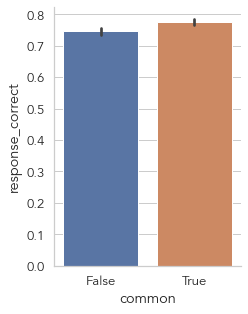

In [331]:
# How does accuracy change across condition?

# Are people more accurate in common trials?

g = sns.catplot(data=df_zip[~df_zip.flagRT],
#                 col="composite_duration", 
                x="common",
                y="response_correct", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

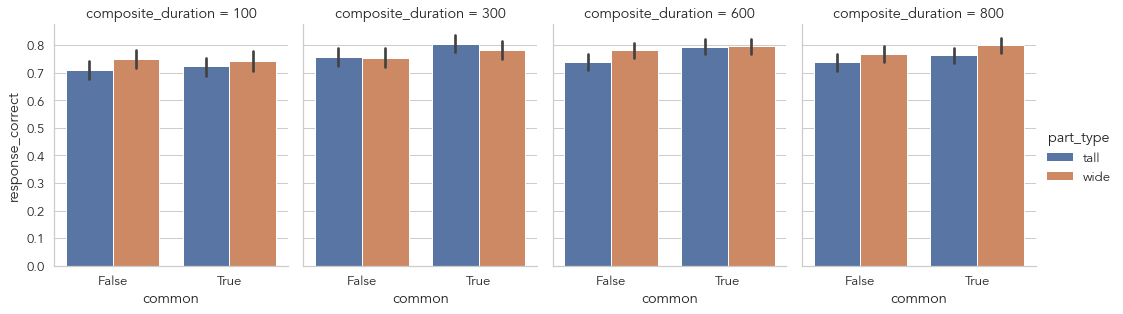

In [332]:
# Are people faster in common trials?

g = sns.catplot(col="composite_duration", 
                x="common",
                y="response_correct", 
                hue="part_type",
                dodge=True,
                kind="bar",
                data=df_zip[df_zip.trial_num > 12],
                height=4.6,
                aspect=0.8)

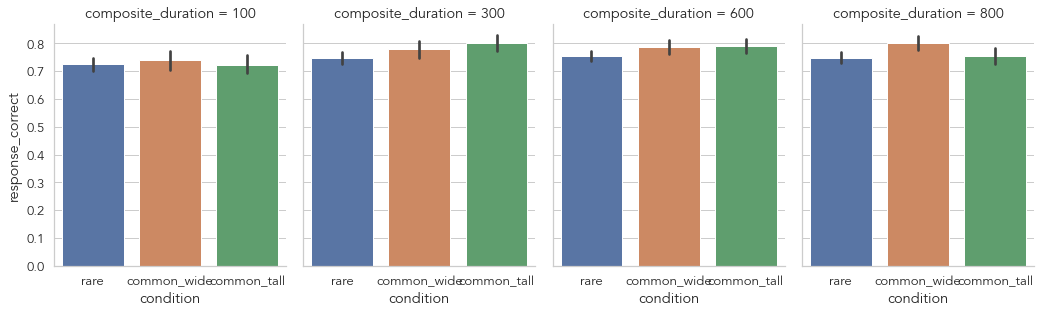

In [333]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="composite_duration", 
#                 x="validity",
                y="response_correct", 
                x="condition",
                order=["rare","common_wide","common_tall"],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

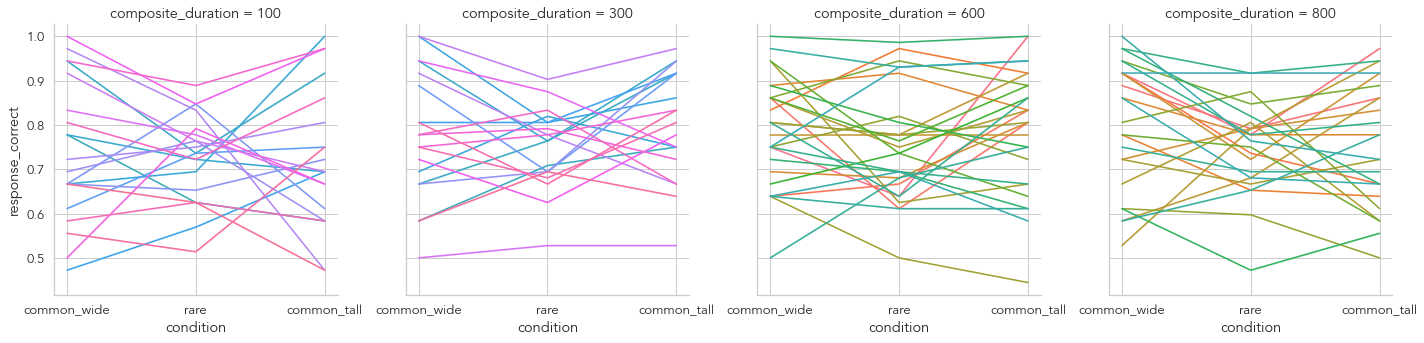

In [334]:
sns.relplot(data = df_zip,
            kind='line',
            col="composite_duration",
            x= "condition",
            y="response_correct",
            hue='gameID',
            ci=False,
            legend=False,)

### RT

No handles with labels found to put in legend.


Text(0.5, 1.0, 'RT')

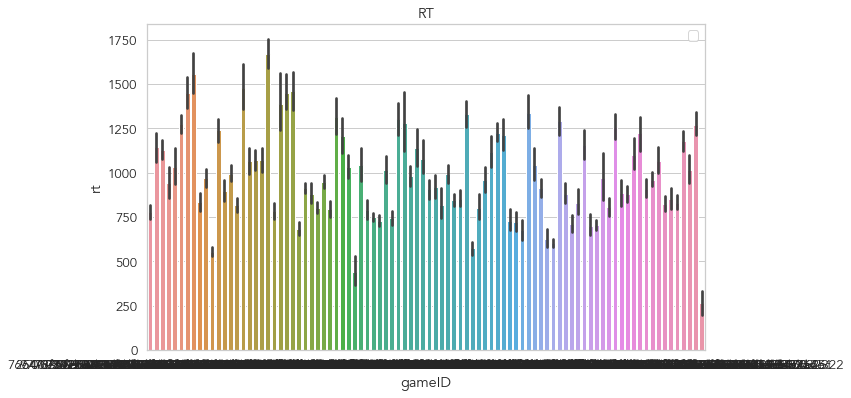

In [335]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip[~df_zip['flagRT']], 
              y="rt", 
              x="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('RT')

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rt', ylabel='Density'>

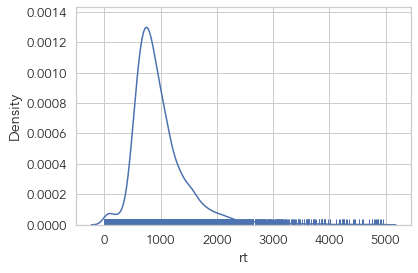

In [336]:
# sns.distplot(data=df_zip, y='rt', x="trial_index")
sns.distplot(df_zip.rt[~df_zip.flagRT], rug=True, hist=False)

<AxesSubplot:xlabel='rt', ylabel='Count'>

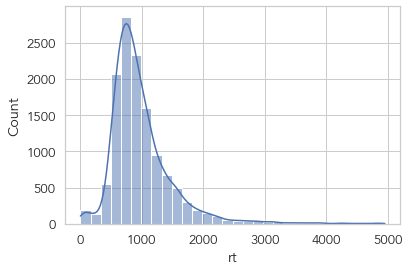

In [337]:
# sns.distplot(df_zip[(~df_zip.flagRT)].rt, rug=True, hist=False)

sns.histplot(data=df_zip[(~df_zip.flagRT)], x="rt", bins=30, kde=True)

No handles with labels found to put in legend.


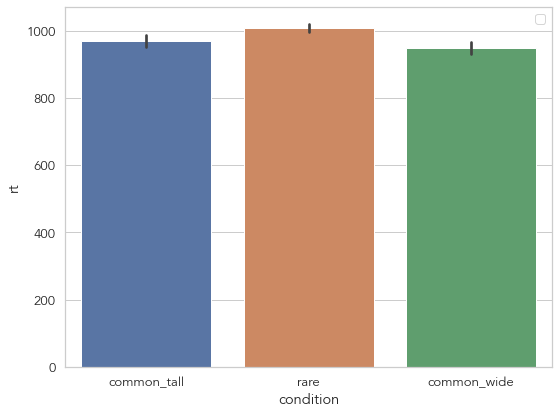

In [338]:
# Are people faster in rare/ commmon trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x= "condition")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

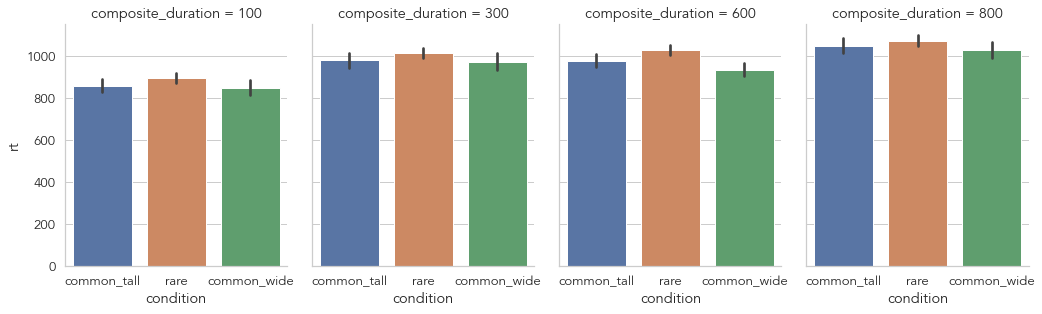

In [339]:
# Are people more accurate in compatible trials?

g = sns.catplot(data=df_zip[~df_zip.flagRT], 
                col="composite_duration", 
#                 x="validity",
                y="rt", 
                x="condition",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

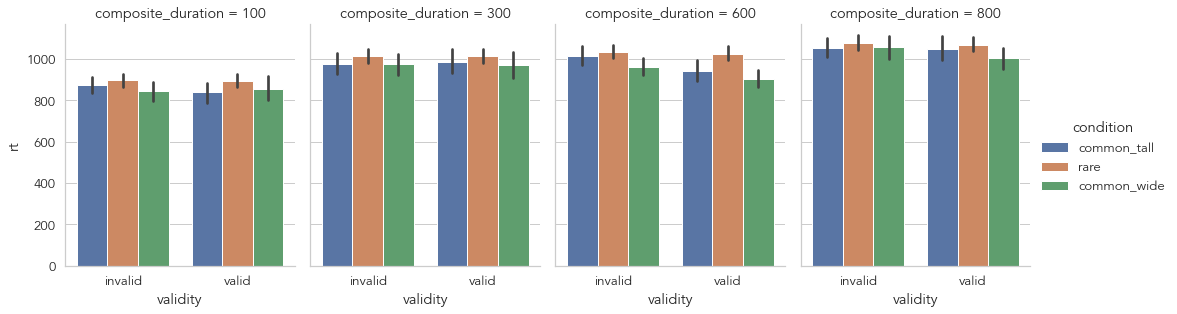

In [340]:
# Are people faster in compatible trials?

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="rt", 
                hue="condition",
                dodge=True,
                kind="bar",
                data=df_zip[~df_zip.flagRT],
                height=4.6,
                aspect=0.8)

### Is there a speed accuracy trade-off?

In [341]:
df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

<AxesSubplot:xlabel='response_correct', ylabel='rt'>

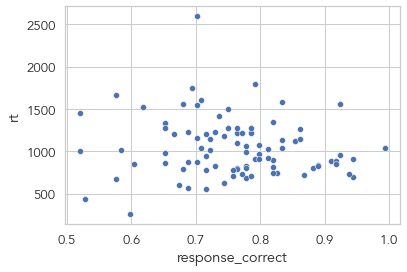

In [342]:
# are people responding slower 

sns.scatterplot(data=df_zip_ppt_means,
               y='rt',
               x='response_correct',)

In [343]:
df_zip_ppt_means = df_zip.groupby(['gameID','common']).mean()

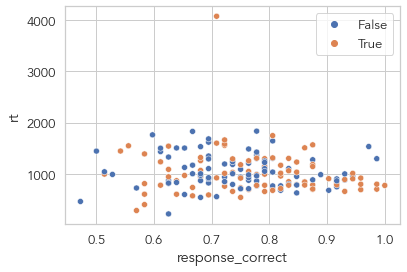

In [344]:
# are people responding slower 

sns.scatterplot(data=df_zip_ppt_means,
               y='rt',
               x='response_correct',
               hue='common',)
plt.legend(bbox_to_anchor=(1.0,1))

No handles with labels found to put in legend.


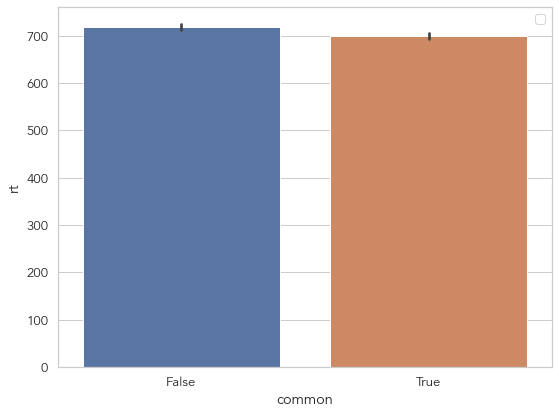

In [345]:
# Is something different going on when people respond quickly?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[df_zip.rt<1000], 
                y= "rt",
#                 x = "composite_duration",
                x= "common",)# , hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

### d' analysis

In [346]:
from scipy.stats import norm

Z = norm.ppf

In [351]:
def d_primes(df):
    
    # find hit rate H, proportion of yes trials with response M
    #df_zip[(df_zip.response=='m') & (df_zip.validity == 'valid')]
    yes_trials = df[df.validity=='valid']
    
    H = len(yes_trials[yes_trials.response==df[df.validity=='valid']['expected_response']])/ len(yes_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_hit = 0.5 / len(yes_trials)
    if H == 1: 
#         H = 1 - half_hit
        H = 0.9999
    if H == 0: 
#         H = half_hit
        H = 0.0001
    

    # find false alarm rate F, proportion of no trials with response M
    no_trials = df[df.validity=='invalid']
    
    F = len(no_trials[no_trials.response!=df[df.validity=='invalid']['expected_response']])/ len(no_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_fa = 0.5 / len(no_trials)
    if F == 1: 
#         F = 1 - half_fa
        F = 0.9999
    if F == 0: 
#         F = half_fa
        F = 0.0001
    
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [370]:
d_blocks = df_zip[~df_zip.flagRT].groupby(['gameID','block_number']).apply(d_primes).reset_index()
d_blocks = d_blocks.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='block_number', ylabel='d_prime'>

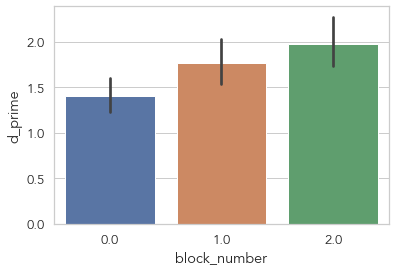

In [371]:
sns.barplot(data = d_blocks,
            y = 'd_prime',
            x = 'block_number')

In [357]:
d_commmon = df_zip[~df_zip.flagRT].groupby(['gameID','common']).apply(d_primes).reset_index()
d_commmon = d_commmon.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='common', ylabel='d_prime'>

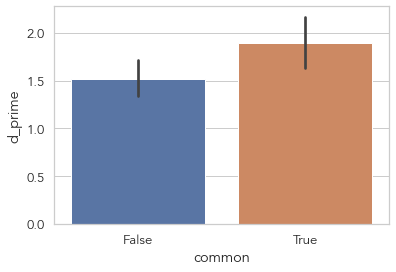

In [358]:
sns.barplot(data = d_commmon,
            y = 'd_prime',
            x = 'common')

In [359]:
d_common_duration = df_zip[~df_zip.flagRT].groupby(['gameID','common','composite_duration']).apply(d_primes).reset_index()
d_common_duration = d_common_duration.rename(columns = {0: 'd_prime'})
d_common_duration

,gameID,common,composite_duration,d_prime
0,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,100,2.468319
1,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,True,100,3.507725
2,0023-f256dea4-1f52-466b-aeac-bb16f9ecc672,False,600,0.557530
3,0023-f256dea4-1f52-466b-aeac-bb16f9ecc672,True,600,1.946959
4,0174-8d01a4e4-fb35-4dc3-9ce8-e2f1f8f360e0,False,300,2.881927
...,...,...,...,...
175,9836-7ab1f26f-97fb-4046-84f9-a1133e1493cd,True,100,0.457852
176,9894-fd23fbc3-58cd-4789-a692-6d680b6ce841,False,600,0.028869
177,9894-fd23fbc3-58cd-4789-a692-6d680b6ce841,True,600,0.194250
178,9959-0623a365-b7b9-412a-8759-d5c01543555a,False,100,1.475910


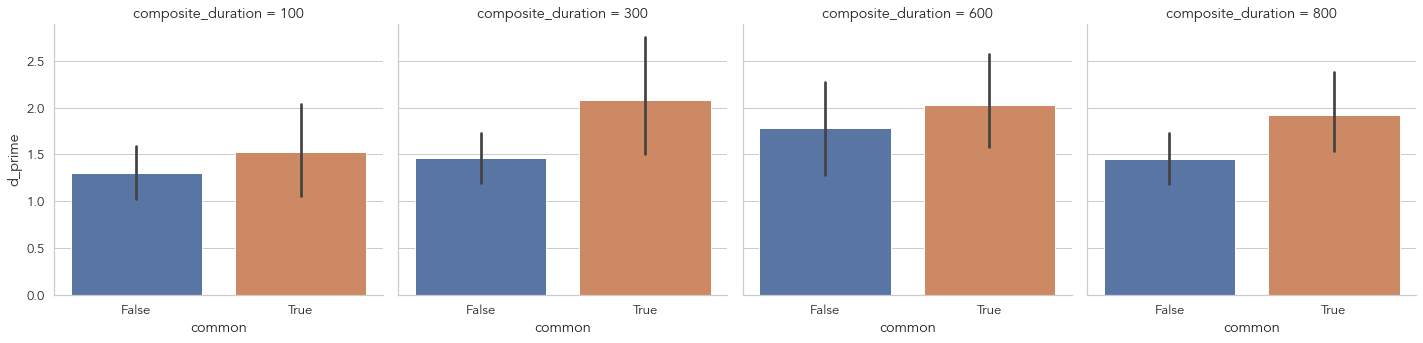

In [360]:
sns.catplot(data = d_common_duration,
            col = 'composite_duration',
            y = 'd_prime',
            x = 'common',
            kind='bar')

In [361]:
d_common_block = df_zip[~df_zip.flagRT].groupby(['gameID','common','block_number']).apply(d_primes).reset_index()
d_common_block = d_common_block.rename(columns = {0: 'd_prime'})
d_common_block

,gameID,common,block_number,d_prime
0,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,0.0,2.057484
1,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,1.0,5.102011
2,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,2.0,2.350416
3,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,True,0.0,5.102011
4,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,True,1.0,5.102011
...,...,...,...,...
535,9959-0623a365-b7b9-412a-8759-d5c01543555a,False,1.0,2.765988
536,9959-0623a365-b7b9-412a-8759-d5c01543555a,False,2.0,1.813721
537,9959-0623a365-b7b9-412a-8759-d5c01543555a,True,0.0,2.057484
538,9959-0623a365-b7b9-412a-8759-d5c01543555a,True,1.0,2.057484


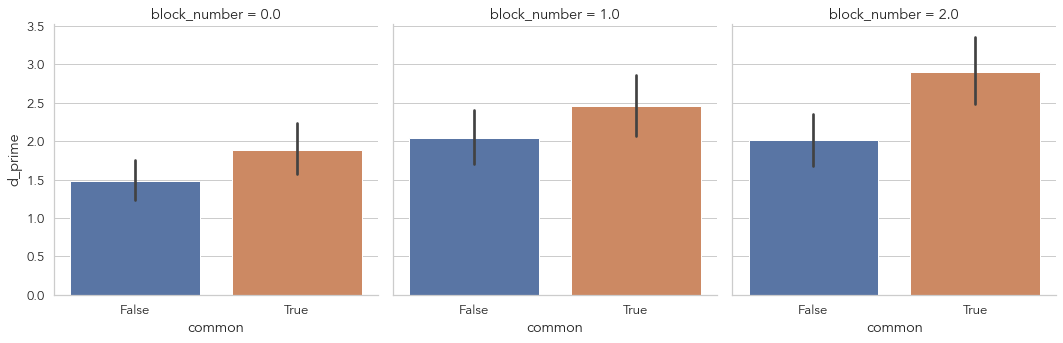

In [362]:
sns.catplot(data = d_common_block,
            col = 'block_number',
            y = 'd_prime',
            x = 'common',
            kind='bar')

In [363]:
d_block_duration = df_zip.groupby(['gameID','block_number','composite_duration']).apply(d_primes).reset_index()
d_block_duration = d_block_duration.rename(columns = {0: 'd_prime'})
d_block_duration

,gameID,block_number,composite_duration,d_prime
0,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,0.0,100,2.533344
1,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,1.0,100,3.463329
2,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,2.0,100,2.765988
3,0023-f256dea4-1f52-466b-aeac-bb16f9ecc672,0.0,600,1.105217
4,0023-f256dea4-1f52-466b-aeac-bb16f9ecc672,1.0,600,1.468989
...,...,...,...,...
265,9894-fd23fbc3-58cd-4789-a692-6d680b6ce841,1.0,600,0.326094
266,9894-fd23fbc3-58cd-4789-a692-6d680b6ce841,2.0,600,0.105795
267,9959-0623a365-b7b9-412a-8759-d5c01543555a,0.0,100,1.130857
268,9959-0623a365-b7b9-412a-8759-d5c01543555a,1.0,100,2.350416


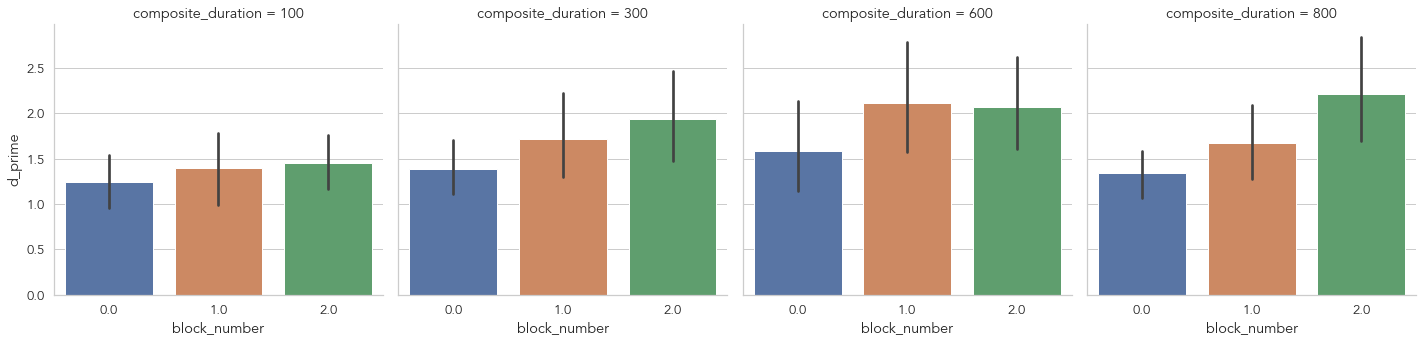

In [364]:
sns.catplot(data = d_block_duration,
            col = 'composite_duration',
            y = 'd_prime',
            x = 'block_number',
            kind='bar')

In [365]:
d_compatibility_block_duration = df_zip.groupby(['gameID','common','block_number','composite_duration']).apply(d_primes).reset_index()
d_compatibility_block_duration = d_compatibility_block_duration.rename(columns = {0: 'd_prime'})
d_compatibility_block_duration

,gameID,common,block_number,composite_duration,d_prime
0,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,0.0,100,2.057484
1,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,1.0,100,5.102011
2,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,False,2.0,100,2.350416
3,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,True,0.0,100,5.102011
4,0016-de5f682d-6599-4aa5-a311-3050bb069d0c,True,1.0,100,5.102011
...,...,...,...,...,...
535,9959-0623a365-b7b9-412a-8759-d5c01543555a,False,1.0,100,2.765988
536,9959-0623a365-b7b9-412a-8759-d5c01543555a,False,2.0,100,1.813721
537,9959-0623a365-b7b9-412a-8759-d5c01543555a,True,0.0,100,2.057484
538,9959-0623a365-b7b9-412a-8759-d5c01543555a,True,1.0,100,2.057484


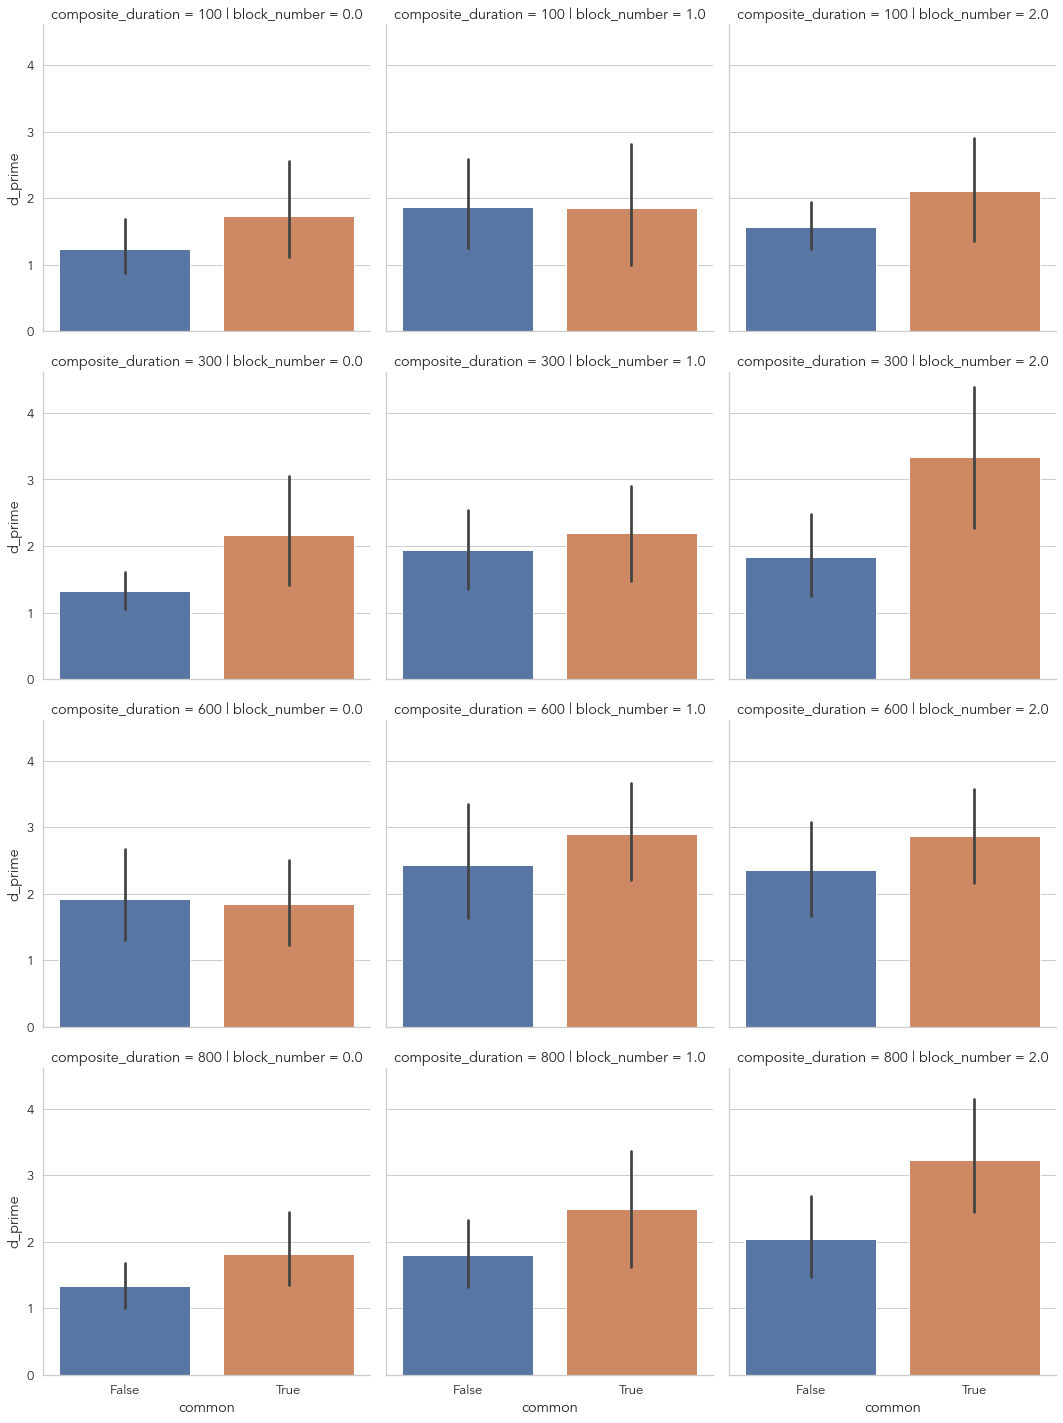

In [366]:
sns.catplot(data = d_compatibility_block_duration,
            col = 'block_number',
            row = 'composite_duration',
            y = 'd_prime',
            x = 'common',
            kind='bar')

### Duration

How does the amount of time the composite stimulus is displayed for affect things?

No handles with labels found to put in legend.


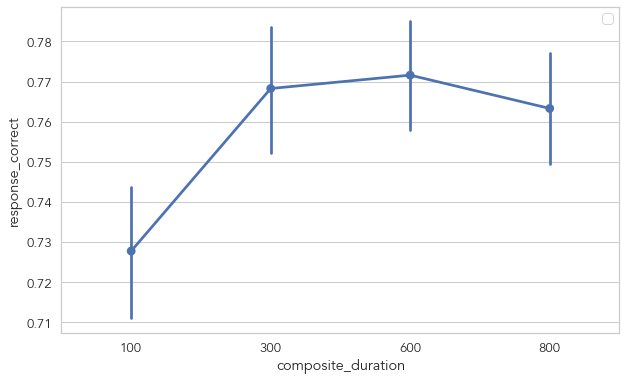

In [367]:
fig = plt.figure(figsize=(10,6))
sns.pointplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration",
#               hue="compatibility"
             )
plt.legend(bbox_to_anchor=(1.0,1))

<AxesSubplot:xlabel='composite_duration', ylabel='rt'>

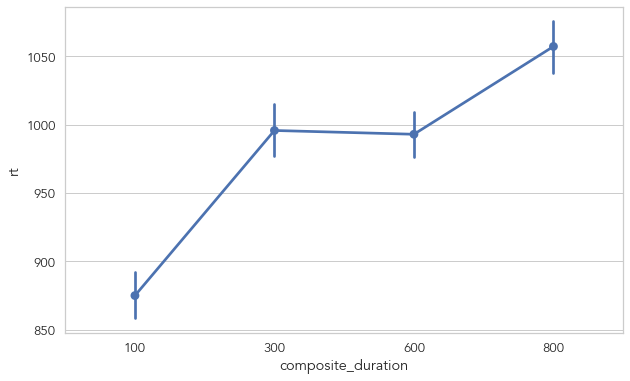

In [372]:
fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt", 
              x="composite_duration")

## 'power' analysis

Goal: find out how many trials we need to see result
Plot n trials against Cohen's d


In [374]:
df_zip.gameID.nunique()

90

In [496]:
# accuracy

n_trial = 20

# sample n trials. (is sampling the right move here? should I be picking the first n trials? first n per block?)
df_sample = df_zip.groupby('gameID').sample(n_trial).groupby('common') #swap in sample(n) for head(n)?

df_sample_summary = df_sample.agg({'response_correct':['mean','std'],
                                   'rt':['mean','std']})

# calculate cohens d

# diff in mean
numerator = np.abs(df_sample_summary['response_correct','mean'][True] -\
                   df_sample_summary['response_correct','mean'][False])

# population std ~ root mean square standard deviation
denominator = np.sqrt(((df_sample_summary['response_correct','std'][True])**2 +\
                 (df_sample_summary['response_correct','std'][False])**2)/2)


d = numerator/denominator
d

0.07878004015818645

In [515]:
df_sample = df_zip.groupby(['common','gameID']).sample(int(12/2)).groupby('common')

In [517]:
df_sample.groupby('common')

In [506]:
df_sample

,index,_id,rt,stimulus,response,response_correct,stimURL,practice,composite_id,composite_duration,...,response_key_dict,studyLocation,block_number,condition,composite_talls_name,common,flagRT,trial_bin,expected_response,recalculated_response_correct


In [571]:
# accuracy

ds = pd.DataFrame()

for n_trial in [n*12 for n in range(1,12)]:
    
    for it in range(0,10):

        # sample n trials. (is sampling the right move here? should I be picking the first n trials? first n per block?)
        # half trials are common, half are rare
        df_sample = df_zip.groupby(['common','gameID']).sample(int(n_trial/2)).groupby('common')

        df_sample_summary = df_sample.agg({'response_correct':['mean','std'],
                                           'rt':['mean','std']})

        # calculate cohens d

        # diff in mean
        numerator = np.abs(df_sample_summary['response_correct','mean'][True] -\
                           df_sample_summary['response_correct','mean'][False])

        # population std ~ root mean square standard deviation
        denominator = np.sqrt(((df_sample_summary['response_correct','std'][True])**2 +\
                         (df_sample_summary['response_correct','std'][False])**2)/2)


        d = numerator/denominator
        
#         ds[n_trial] += d
        ds = ds.append({'n_trial': n_trial,
                        'cohens_d': d,
                        'it': it}, ignore_index=True)
        

In [572]:
ds

,n_trial,cohens_d,it
0,12.0,0.104107,0.0
1,12.0,0.151346,1.0
2,12.0,0.154595,2.0
3,12.0,0.076958,3.0
4,12.0,0.038119,4.0
...,...,...,...
105,132.0,0.016233,5.0
106,132.0,0.015118,6.0
107,132.0,0.014110,7.0
108,132.0,0.016387,8.0


<AxesSubplot:xlabel='n_trial', ylabel='cohens_d'>

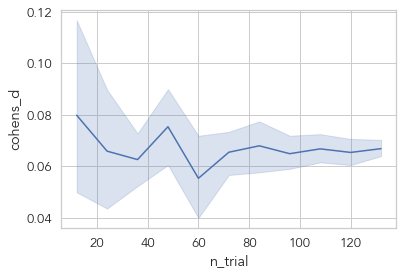

In [570]:
# response correct

sns.lineplot(data = ds,
            x= 'n_trial',
            y='cohens_d')

<AxesSubplot:xlabel='n_trial', ylabel='cohens_d'>

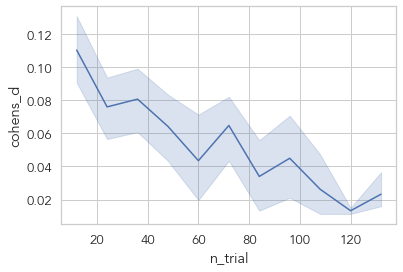

In [573]:
# rt

sns.lineplot(data = ds,
            x= 'n_trial',
            y='cohens_d')

## See if any stimuli or parts are easier than others
Are there any that are too easy or too hard to learn for the building study?


In [574]:
import requests

In [587]:
def show(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(1,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [584]:
composite_urls = df_zip.stimURL.unique()

In [585]:
composite_id_order = [url.split('composites_silhouette_')[1].split('.')[0] for url in composite_urls]
composite_id_order

['talls_116_102',
 'talls_100_102',
 'talls_127_122',
 'talls_102_114',
 'talls_118_111',
 'talls_097_102',
 'talls_116_126',
 'talls_101_097',
 'talls_115_127',
 'talls_100_125',
 'talls_125_118',
 'talls_122_121',
 'talls_122_126',
 'talls_114_111',
 'talls_126_115',
 'talls_097_116',
 'talls_101_115',
 'talls_101_111',
 'talls_118_115']

talls_116_102


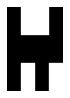

talls_100_102


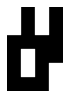

talls_127_122


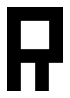

talls_102_114


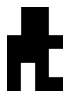

talls_118_111


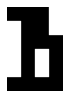

talls_097_102


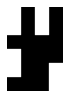

talls_116_126


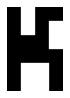

talls_101_097


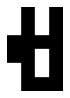

talls_115_127


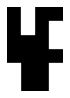

talls_100_125


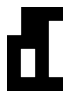

talls_125_118


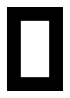

talls_122_121


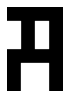

talls_122_126


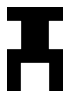

talls_114_111


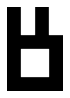

talls_126_115


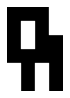

talls_097_116


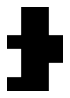

talls_101_115


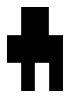

talls_101_111


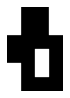

talls_118_115


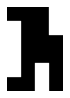

In [595]:
_ = [(print(url.split('composites_silhouette_')[1].split('.')[0]), show(url)) for url in composite_urls]

In [590]:
df_zip.composite_talls_name

0        talls_125_118
1        talls_122_121
2        talls_100_125
3        talls_102_114
4        talls_101_115
             ...      
13531    talls_101_111
13532    talls_100_118
13533    talls_101_111
13534    talls_125_118
13535    talls_102_114
Name: composite_talls_name, Length: 12960, dtype: object

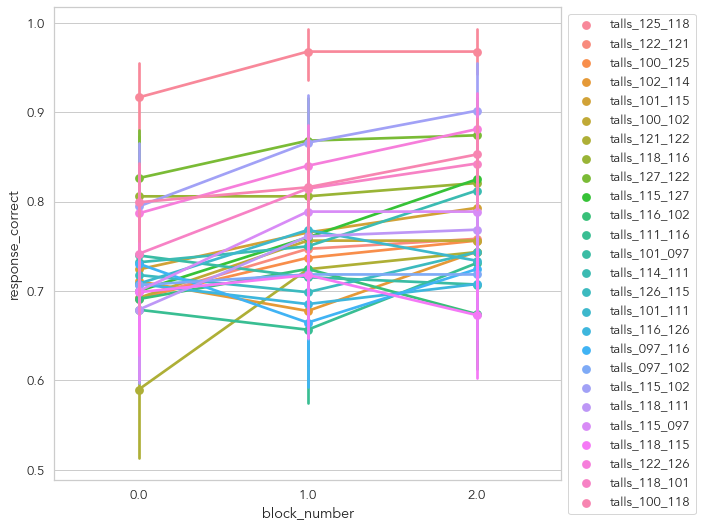

In [602]:
# difference in accuracy across blocks for each composite

fig = plt.figure(figsize=(10,8))

c = sns.pointplot(data=df_zip, 
                y= "response_correct", 
                x= "block_number",
                hue="composite_talls_name",
                legend=None,
                alpha=0.2,)
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

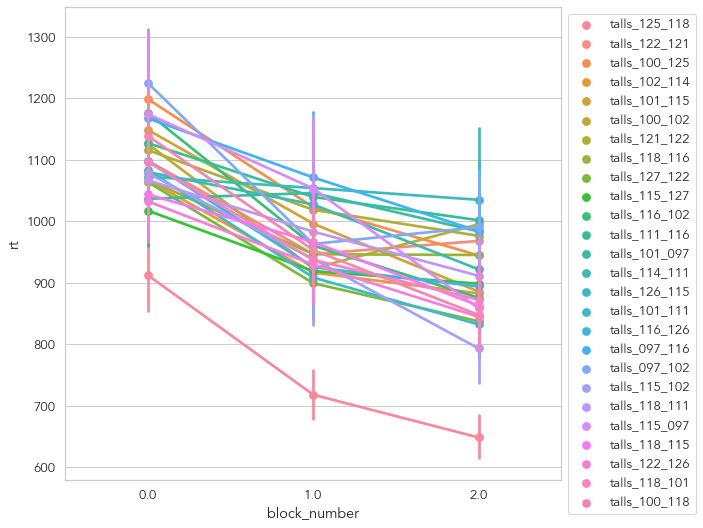

In [617]:
# difference in rt across blocks for each composite

fig = plt.figure(figsize=(10,8))

c = sns.pointplot(data=df_zip[~df_zip.flagRT], #.query('common==False'), 
                y= "rt", 
                x= "block_number",
                hue="composite_talls_name",
                legend=None,
                alpha=0.2,)
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

In [639]:
# how many times was each composite one of the common stims?

df_zip.groupby(['common','composite_talls_name'])['gameID'].apply(lambda g: g.nunique())

common  composite_talls_name
False   talls_097_102           83
        talls_097_116           83
        talls_100_102           84
        talls_100_118           71
        talls_100_125           84
        talls_101_097           87
        talls_101_111           77
        talls_101_115           85
        talls_102_114           79
        talls_111_116           86
        talls_114_111           88
        talls_115_097           90
        talls_115_102           88
        talls_115_127           80
        talls_116_102           82
        talls_116_126           82
        talls_118_101           82
        talls_118_111           86
        talls_118_115           84
        talls_118_116           86
        talls_121_122           84
        talls_122_121           82
        talls_122_126           76
        talls_125_118           84
        talls_126_115           84
        talls_127_122           83
True    talls_097_102            7
        talls_097_116     

<Figure size 864x720 with 0 Axes>

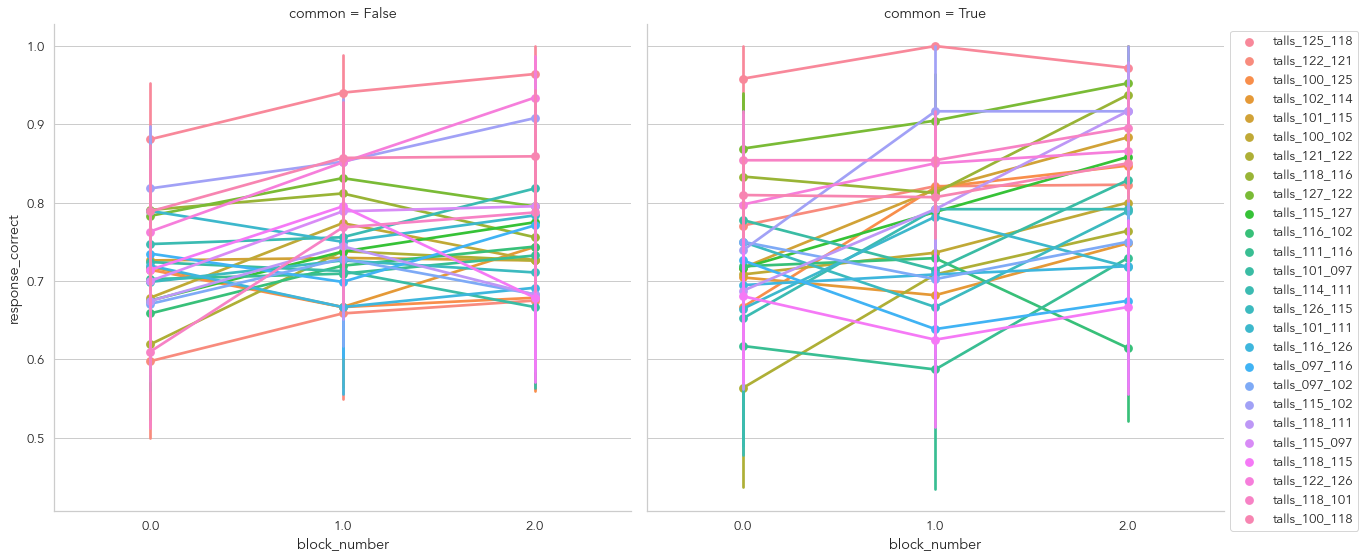

In [629]:
# difference in accuracy across blocks for each composite when rare vs. when common

fig = plt.figure(figsize=(12,10))

c = sns.catplot(data=df_zip[~df_zip.flagRT],
                col="common",
                y= "response_correct", 
                x= "block_number",
                hue="composite_talls_name",
                legend=None,
                kind='point',
                height=8,
                aspect=1.2)
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

<Figure size 864x720 with 0 Axes>

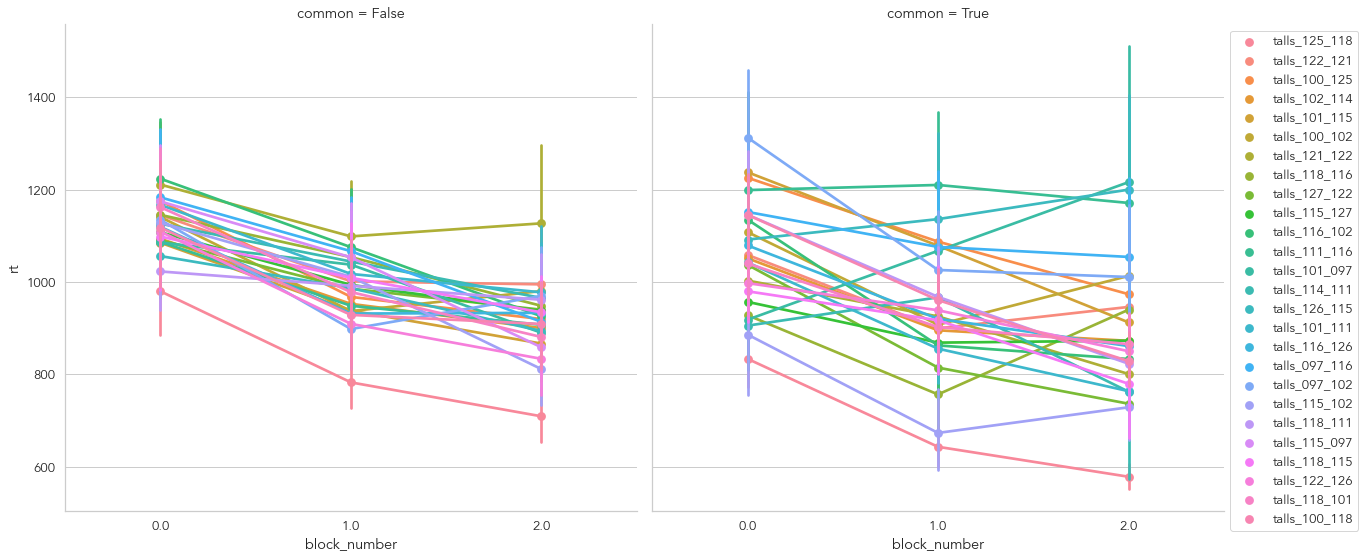

In [626]:
# difference in rt across blocks for each composite when rare vs. when common

fig = plt.figure(figsize=(12,10))

c = sns.catplot(data=df_zip[~df_zip.flagRT],
                col="common",
                y= "rt", 
                x= "block_number",
                hue="composite_talls_name",
                legend=None,
                kind='point',
                height=8,
                aspect=1.2)
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

## Learning effects

Looks like there are substantial learning effects

In [ ]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "block_number",
                hue="composite_duration",
#                 ci=None,
                legend=None)
# plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "rt", 
                x= "block_number",
                hue="composite_duration")
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "gameID",
                ci=False,
                legend=False)

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "common")
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

### Do people become more accurate over time?

In [ ]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct",
                x = "block_number",
                hue = "common")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt",
                x = "block_number",
                hue = "common")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

They do get a bit better

Let's see if this happens for all durations

In [ ]:
# rt over blocks, broken down by duration

g = sns.catplot(col="block_number",
                row="composite_duration", 
                y="response_correct", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

### RT over time

In [ ]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt",
                x = "block_number",
                hue = "compatibility",
                hue_order = compatibility_order,)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

They get a lot faster with practice!

Let's see if this happens for all durations

In [ ]:
# rt over blocks, broken down by duration

g = sns.catplot(col="block_number",
                row="composite_duration", 
                y="rt", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

### Validity

Looks like valid trials might be a little easier

In [ ]:
# are valid trials more accurate?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="validity"
                )

plt.tight_layout()

In [ ]:
# Are people more accurate in valid trials in all conditions?

g = sns.catplot(col="composite_duration", 
                hue="validity",
                y="response_correct", 
                x="compatibility",
                order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

In [ ]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="validity")

plt.tight_layout()

In [ ]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                hue="validity",
                x="block_number")

plt.tight_layout()

### Part type (tall vs. wide)

Vertical decomposition is easier

In [ ]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="part_type")

plt.tight_layout()

In [ ]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="part_type")

plt.tight_layout()

### Stimuli

Are some stims easier than others?

In [ ]:
import requests

In [ ]:
stim_order = ['https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_100_118.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_122_127.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_102_126.png']

In [ ]:
composite_id_order = [url.split('composites_silhouette_')[1].split('.')[0] for url in stim_order]
composite_id_order

In [ ]:
def show(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
print(stim_order[0].split('silhouette_')[-1].split('.')[0])
show(stim_order[0])

In [ ]:
print(stim_order[1].split('silhouette_')[-1].split('.')[0])
show(stim_order[1])

In [ ]:
print(stim_order[2].split('silhouette_')[-1].split('.')[0])
show(stim_order[2])

One of the stimuli (talls_100_118) is considerably easier than the others.

In [ ]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                order= composite_id_order)


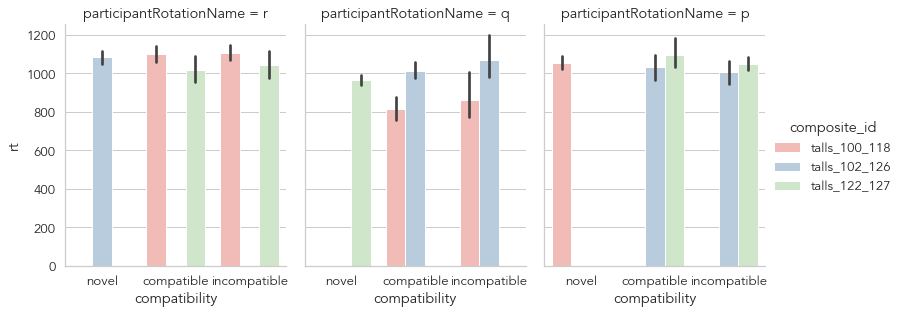

In [1735]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                y="rt", 
                hue="composite_id",
                palette='Pastel1',
                x="compatibility",
                order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

In [ ]:
df_zip.participantRotationName

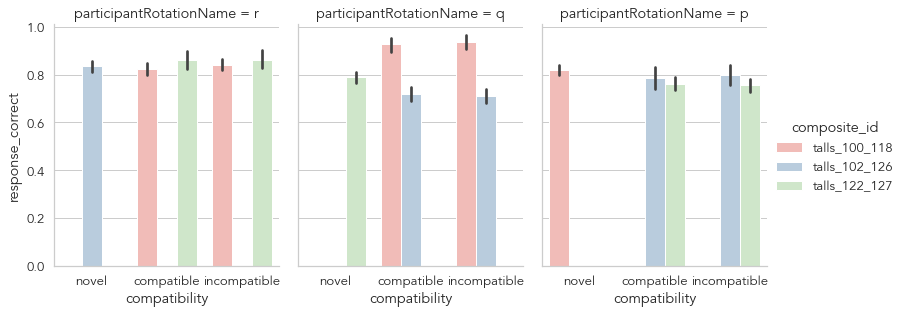

In [1674]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                y="response_correct", 
                hue="composite_id",
                palette='Pastel1',
                x="compatibility",
                order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

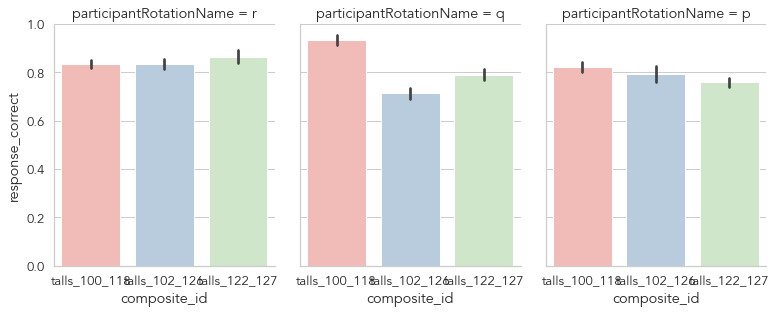

In [1676]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                y="response_correct", 
#                 hue="composite_id",
                palette='Pastel1',
                x="composite_id",
#                 order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

In [1671]:
df_zip.groupby(['participantRotationName','participant_condition'])

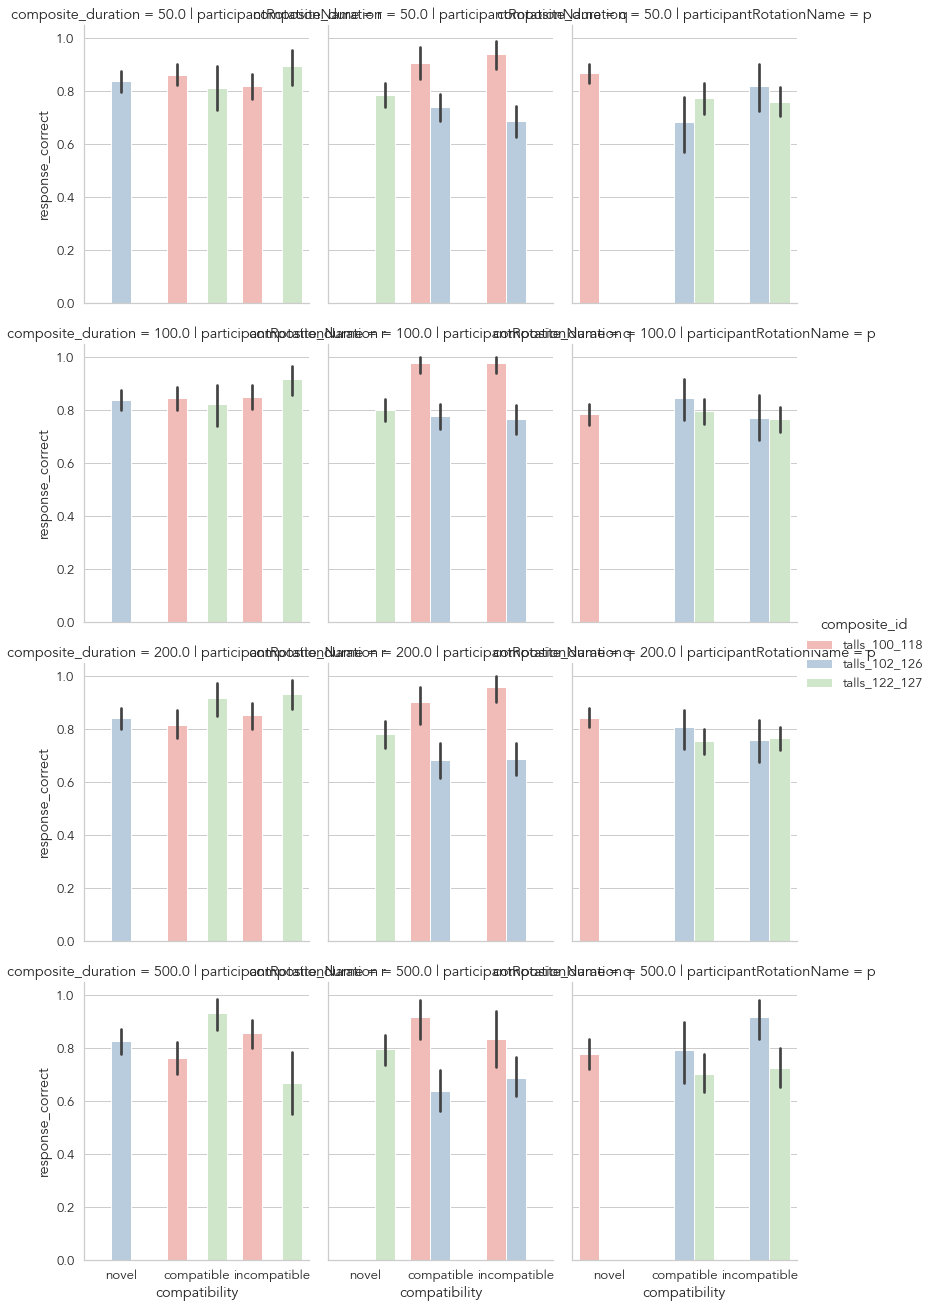

In [1642]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                row="composite_duration",
                y="response_correct", 
                hue="composite_id",
                palette='Pastel1',
                x="compatibility",
                order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

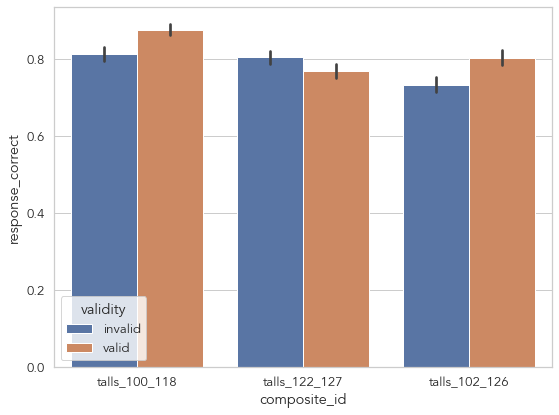

In [1645]:
# Is either stimulus easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                hue="validity",
               order= composite_id_order)

plt.tight_layout()

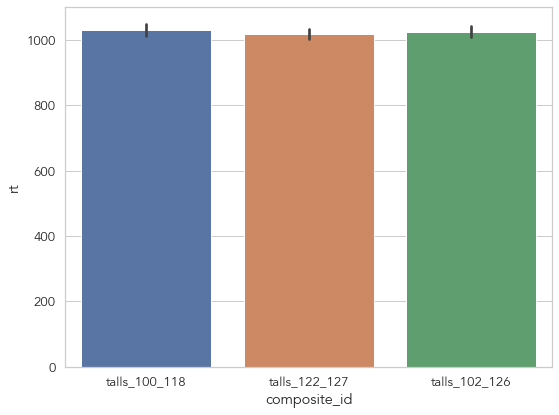

In [1644]:
# Is any composite easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order= composite_id_order)

plt.tight_layout()

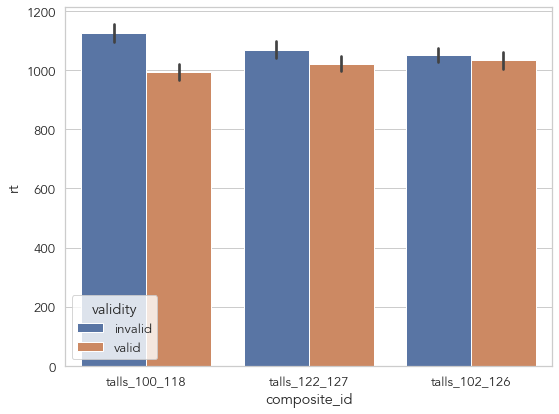

In [899]:
# Is either part type easier at saying one particular way- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order = composite_id_order,
                hue="validity")

plt.tight_layout()

In [900]:
df_zip.columns

Index(['level_0', 'index', '_id', 'rt', 'stimulus', 'response',
       'response_correct', 'stimURL', 'composite_id', 'rep', 'block_number',
       'composite_duration', 'gap_duration', 'chunk_duration',
       'participant_condition', 'compatible_trial', 'validity',
       'composite_talls_name', 'composite_wides_name', 'part_type', 'part_a',
       'part_b', 'participantRotationName', 'participantRotation',
       'stimVersion', 'stimVersionInd', 'compatible_condition', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'gameID', 'built_parts',
       'compatibility', 'trial_bin', 'flagRT', 'trial_num'],
      dtype='object')

In [390]:
# Is either part type easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "trial_bin",
                hue="validity")

plt.tight_layout()

ValueError: Could not interpret value `trial_bin` for parameter `x`

<Figure size 576x432 with 0 Axes>

## Stimuli

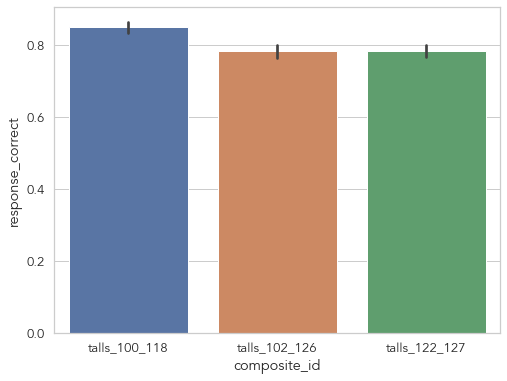

In [147]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id")
#                 hue="composite_id")


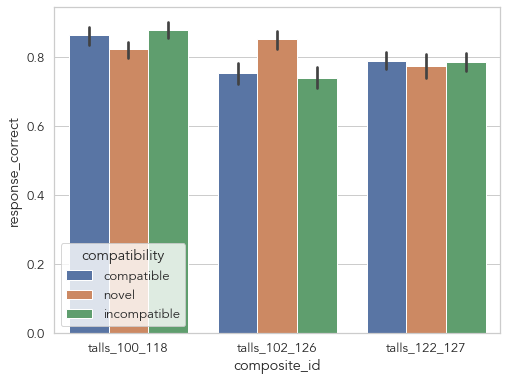

In [149]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
               hue="compatibility")


In [135]:
df_zip.columns

Index(['index', '_id', 'rt', 'stimulus', 'response', 'response_correct',
       'stimURL', 'composite_id', 'rep', 'block_number', 'composite_duration',
       'gap_duration', 'chunk_duration', 'participant_condition',
       'compatible_trial', 'validity', 'composite_talls_name',
       'composite_wides_name', 'part_type', 'part_a', 'part_b',
       'participantRotationName', 'participantRotation', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'datatype', 'experimentName',
       'iterationName', 'gameID', 'compatibility', 'trial_bin', 'flagRT',
       'trial_num'],
      dtype='object')

In [128]:
df_zip[['participantRotation','participantRotationName']].iloc[0][0]

{'B': 'talls_122_127&wides_025_023',
 'novel': 'talls_102_126&wides_024_011',
 'A': 'talls_100_118&wides_013_010'}

In [132]:
df_zip[['participantRotation','participantRotationName']].iloc[200][0]

{'novel': 'talls_122_127&wides_025_023',
 'A': 'talls_102_126&wides_024_011',
 'B': 'talls_100_118&wides_013_010'}

In [ ]:
df_zip['participantRotation'][0]

In [339]:
df_zip.com

0       talls_100_
1       wides_025_
2       wides_013_
3       talls_122_
4       talls_100_
           ...    
1327    wides_024_
1328    wides_013_
1329    wides_011_
1330    wides_025_
1331    talls_126_
Name: part_a, Length: 1332, dtype: object

In [375]:
# part a
'composite_' + df_zip.part_type + 's_name'

0       composite_talls_name
1       composite_wides_name
2       composite_wides_name
3       composite_talls_name
4       composite_talls_name
                ...         
1327    composite_wides_name
1328    composite_wides_name
1329    composite_wides_name
1330    composite_wides_name
1331    composite_talls_name
Name: part_type, Length: 1332, dtype: object

In [388]:
df_zip.composite_talls_name.apply(lambda x: x.split('_')[-2:])

0       [122, 127]
1       [102, 126]
2       [122, 127]
3       [102, 126]
4       [100, 118]
           ...    
1327    [102, 126]
1328    [100, 118]
1329    [100, 118]
1330    [122, 127]
1331    [100, 118]
Name: composite_talls_name, Length: 1332, dtype: object

In [387]:
df_zip.composite_wides_name.apply(lambda x: x.split('_')[-2:])

0       [025, 023]
1       [024, 011]
2       [025, 023]
3       [024, 011]
4       [013, 010]
           ...    
1327    [024, 011]
1328    [013, 010]
1329    [013, 010]
1330    [025, 023]
1331    [013, 010]
Name: composite_wides_name, Length: 1332, dtype: object

In [392]:
# part a

df_zip.part_a.apply(lambda x: x.split('_')[1])

0       100
1       025
2       013
3       122
4       100
       ... 
1327    024
1328    013
1329    011
1330    025
1331    126
Name: part_a, Length: 1332, dtype: object

In [396]:
df_zip.columns

0       invalid
1       invalid
2       invalid
3       invalid
4         valid
         ...   
1327      valid
1328      valid
1329    invalid
1330    invalid
1331    invalid
Name: validity, Length: 1332, dtype: object

In [414]:
def check_parts(row):
    
    part_type = row.part_type
    part_a = row.part_a.split('_')[1]
    part_b = row.part_b.split('_')[1]
    
    
    if row.validity == 'valid':
        if part_type == 'tall':
            return part_type + 's_'+ part_a + '_' + part_b == row.composite_talls_name
        else:
            return part_type + 's_'+ part_a + '_' + part_b == row.composite_wides_name
    else: # invalid trials
        if part_type == 'wide':
            return (part_a not in row.composite_wides_name.split('_')[-2:]) and \
                   (part_b not in row.composite_wides_name.split('_')[-2:]) 
        else:
            return (part_a not in row.composite_talls_name.split('_')[-2:]) and \
                   (part_b not in row.composite_talls_name.split('_')[-2:]) 
    
    return (part_type, part_a, part_b)
    

dodgy_trials = df_zip.apply(lambda row: not check_parts(row), axis=1)


In [439]:
df_zip.columns

Index(['Unnamed: 0', 'index', '_id', 'rt', 'stimulus', 'response',
       'response_correct', 'stimURL', 'composite_id', 'rep', 'block_number',
       'composite_duration', 'gap_duration', 'chunk_duration',
       'participant_condition', 'compatible_trial', 'validity',
       'composite_talls_name', 'composite_wides_name', 'part_type', 'part_a',
       'part_b', 'participantRotationName', 'participantRotation',
       'stimVersion', 'stimVersionInd', 'compatible_condition', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'workerID', 'gameID',
       'compatibility', 'trial_bin', 'flagRT'],
      dtype='object')

In [458]:
df_zip[dodgy_trials][['gameID','part_a','part_b','part_type','composite_talls_name',
                      'composite_wides_name','validity','rep','compatibility']]#.groupby(['gameID','compatibility']).count()                     
                     
                     
                     

,gameID,part_a,part_b,part_type,composite_talls_name,composite_wides_name,validity,rep,compatibility
58,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,wide_025,wide_011,wide,talls_102_126,wides_024_011,invalid,2,compatible
67,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,tall_122,tall_126,tall,talls_102_126,wides_024_011,invalid,2,incompatible
88,7793-230b9c9f-94fe-4dc2-83cf-0b4841ee723f,tall_102,tall_118,tall,talls_100_118,wides_013_010,invalid,2,compatible
94,7793-230b9c9f-94fe-4dc2-83cf-0b4841ee723f,wide_024,wide_010,wide,talls_100_118,wides_013_010,invalid,2,incompatible
106,2420-26aa2daa-eb8b-4f9d-a573-bf768f18f3a2,wide_013,wide_023,wide,talls_122_127,wides_025_023,invalid,2,incompatible
...,...,...,...,...,...,...,...,...,...
1278,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,wide_025,wide_010,wide,talls_122_127,wides_025_023,invalid,3,compatible
1316,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,tall_100,tall_127,tall,talls_122_127,wides_025_023,invalid,2,incompatible
1317,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,wide_013,wide_023,wide,talls_122_127,wides_025_023,invalid,2,compatible
1321,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,tall_122,tall_118,tall,talls_122_127,wides_025_023,invalid,3,incompatible


In [443]:
# part b
df_zip.part_b.apply(lambda x: x.split('_')[1])

0       126
1       023
2       011
3       127
4       118
       ... 
1327    011
1328    010
1329    025
1330    010
1331    122
Name: part_b, Length: 1332, dtype: object

In [ ]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participantRotationName",
                hue="compatibility")

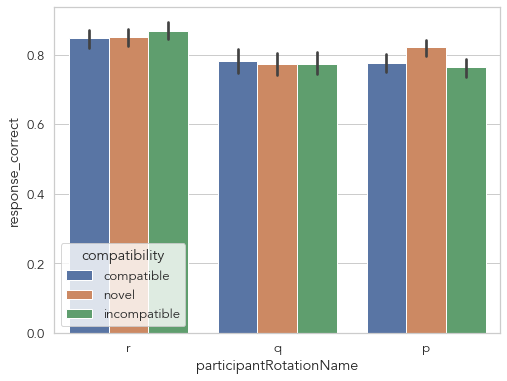

In [98]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participantRotationName",
                hue="compatibility")

### Condition (A vs. B) - DOESN'T APPLY ANYMORE

Is one condition easier than the others?
A looks a bit easier.

In [238]:
# how many people in each condition
df_zip.groupby('gameID').first().value_counts('participant_condition')

participant_condition
1    5
2    5
dtype: int64

#### Participant condition

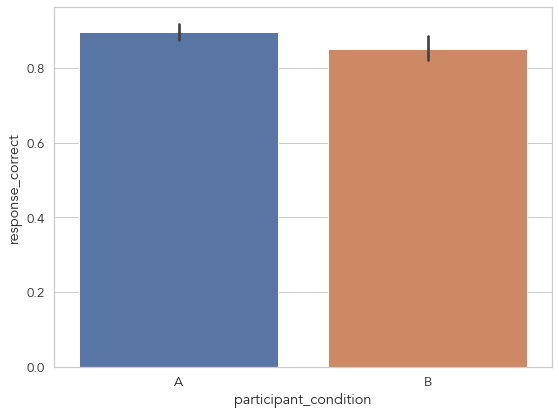

In [767]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participant_condition")

plt.tight_layout()

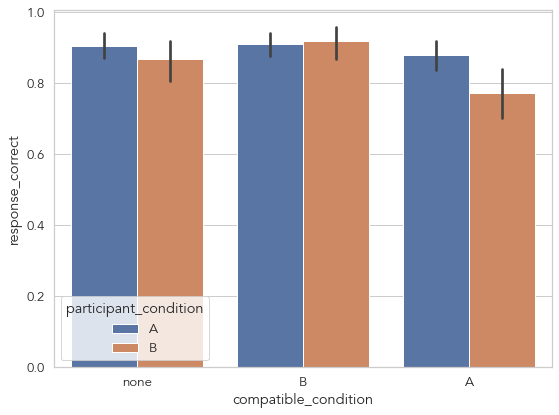

In [768]:
# break down by 

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

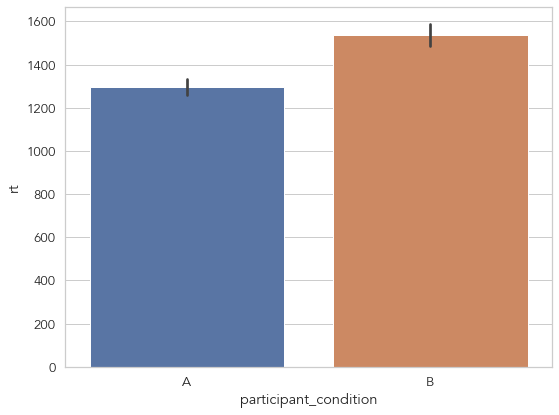

In [769]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "participant_condition")

plt.tight_layout()

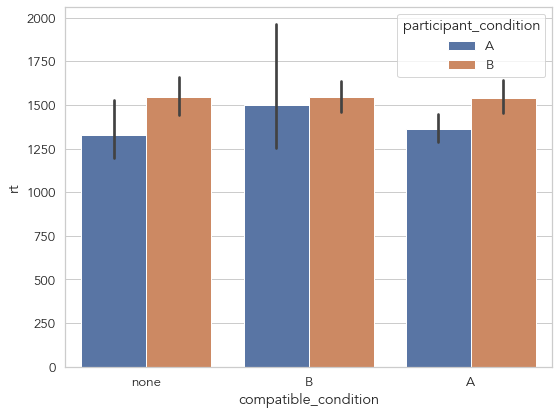

In [770]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

In [1740]:
df_zip.part_a

0        wide_024
1        tall_122
2        tall_102
3        tall_102
4        tall_102
           ...   
10939    tall_100
10940    wide_025
10941    tall_118
10942    tall_102
10943    wide_024
Name: part_a, Length: 10944, dtype: object